# Texture Image Segmentation (Local GPU with CuPy)

**Student ID:** 211805018
**Dataset ID:** Texture Image Segmentation

This notebook addresses the third project assignment: Texture Image Segmentation, adapted to run on a local machine with GPU acceleration using CuPy. The goal is to segment an input image based on its textures, using a provided mask image for training labels. This involves extracting texture features using a 2D sliding window approach and then training a classification model to predict texture patterns. The primary evaluation metric will be Intersection over Union (IoU).

The project will follow the general requirements and the specific instructions provided for this dataset.

**Main Sections in this Notebook:**
1.  Preparation, Library Imports (including CuPy), and Data Loading
2.  Feature Extraction Setup (Sliding Window and GPU-accelerated Texture Feature Functions)
3.  Tabular Data Generation (Optimized for GPU where possible) and Initial Analysis
4.  Data Splitting (for Tabular Data) and Preprocessing (Scaling)
5.  Model Training (Classification), Selection (CV with IoU), and Evaluation
6.  Visualizations (Predicted Segmentation Mask, Feature Importances)
7.  Reporting of Results and Conclusion
---

---
## STAGE 1: PREPARATION AND DATA LOADING

This initial stage focuses on setting up the environment for the texture image segmentation project on a local machine with GPU capabilities. Key tasks include:
*   Importing essential Python libraries, with a try-except block for CuPy to enable GPU acceleration.
*   Defining global constants, including `RANDOM_SEED` and the path to the `PhotoData` directory.
*   Loading the input texture image (`input.png`) and the corresponding mask image (`mask.png`).
*   Performing an initial inspection of these images and processing the mask to identify unique texture classes.
---

### 1.1 Importing Necessary Libraries (with CuPy Check)

This cell imports the libraries required for image loading and manipulation, feature extraction, model building, and evaluation. It includes a check for CuPy to enable GPU acceleration where possible.

In [5]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time # For measuring execution times

# Image Processing Libraries
import cv2 # OpenCV
from PIL import Image 
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern # For CPU-bound texture features
from skimage.filters import gabor_kernel # For Gabor kernels (CPU generation for now)
from skimage import img_as_ubyte, img_as_float
from skimage.color import rgb2gray
# from scipy import ndimage as ndi # If needed

# CuPy for GPU acceleration
CUPY_AVAILABLE = False
cp = np # Default to numpy if cupy is not available or fails
try:
    import cupy
    # Test if a GPU is actually available and usable by CuPy
    if cupy.cuda.runtime.getDeviceCount() > 0:
        cp = cupy # Assign cupy to cp alias
        device_id = 0 
        props = cp.cuda.runtime.getDeviceProperties(device_id)
        print(f"CuPy {cp.__version__} found and will be used. GPU: {props['name'].decode('utf-8')}")
        CUPY_AVAILABLE = True
    else:
        print("CuPy imported, but no CUDA-enabled GPU detected by CuPy. Operations will use NumPy on CPU.")
        cp = np # Fallback to numpy
except ImportError:
    print("UYARI: CuPy kütüphanesi bulunamadı! İşlemler CPU üzerinde NumPy ile devam edecek.")
    print("GPU hızlandırması için lütfen CuPy'yi CUDA versiyonunuzla uyumlu şekilde kurun.")
except Exception as e:
    print(f"UYARI: CuPy import edilirken/GPU kontrol edilirken bir hata oluştu: {e}")
    print("İşlemler CPU üzerinde NumPy ile devam edecek.")


# Scikit-learn Modules
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder # LabelEncoder for mask processing
from sklearn.metrics import jaccard_score, classification_report, confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# For saving the model
import joblib

# Visualization Settings
%matplotlib inline
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import warnings
# warnings.filterwarnings('ignore')

print("\n--- Library Import Summary ---")
if CUPY_AVAILABLE:
    print("CuPy is available and configured for GPU usage.")
else:
    print("CuPy is NOT available or GPU not detected; NumPy will be used for array operations (CPU-bound).")

print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"OpenCV version: {cv2.__version__}")
import skimage
print(f"Scikit-image version: {skimage.__version__}")
import sklearn
print(f"Scikit-learn version: {sklearn.__version__}")

CuPy 13.4.1 found and will be used. GPU: NVIDIA GeForce RTX 3050 Laptop GPU

--- Library Import Summary ---
CuPy is available and configured for GPU usage.
NumPy version: 2.0.2
Pandas version: 2.2.3
OpenCV version: 4.11.0
Scikit-image version: 0.24.0
Scikit-learn version: 1.6.1


### 1.2 Global Settings and Constants

This cell defines global constants and settings for the project.
- `RANDOM_SEED`: For reproducibility.
- `DATASET_DIR`: Path to the directory containing `input.png` and `mask.png`. Since they are in the same directory as the notebook, we use ".".
- `INPUT_IMAGE_NAME` and `MASK_IMAGE_NAME`: Filenames for the input and mask images.
- `WINDOW_SIZE` and `STRIDE`: Parameters for the 2D sliding window feature extraction.

In [6]:
# Constant Values
RANDOM_SEED = 13
DATASET_DIR = "."  # Files are in the same directory as the notebook

INPUT_IMAGE_NAME = "input.png"
MASK_IMAGE_NAME = "mask.png"

# Sliding Window Parameters (can be tuned later)
DEFAULT_WINDOW_SIDE_LENGTH = 10 
STRIDE = 1

print(f"Random Seed: {RANDOM_SEED}")
print(f"Dataset Directory: {DATASET_DIR} (Current working directory)")
print(f"Input Image File: {INPUT_IMAGE_NAME}")
print(f"Mask Image File: {MASK_IMAGE_NAME}")
print(f"Default Window Side Length: {DEFAULT_WINDOW_SIDE_LENGTH} (resulting in a {DEFAULT_WINDOW_SIDE_LENGTH}x{DEFAULT_WINDOW_SIDE_LENGTH} window)")
print(f"Stride: {STRIDE}")

Random Seed: 13
Dataset Directory: . (Current working directory)
Input Image File: input.png
Mask Image File: mask.png
Default Window Side Length: 10 (resulting in a 10x10 window)
Stride: 1


### 1.3 Load and Inspect Images

In this step, we will load the input texture image (`input.png`) and its corresponding mask image (`mask.png`) using OpenCV from the current working directory. We will then display them and inspect their properties such as dimensions and color channels. For the mask image, we will also identify the unique colors/pixel values, as these represent our different texture classes, and create a single-channel label mask.

Attempting to load input image from: .\input.png
--- Input Image ('input.png') ---
Shape: (960, 1280, 3) (Height, Width, Channels)
Data type: uint8
Grayscale shape: (960, 1280)


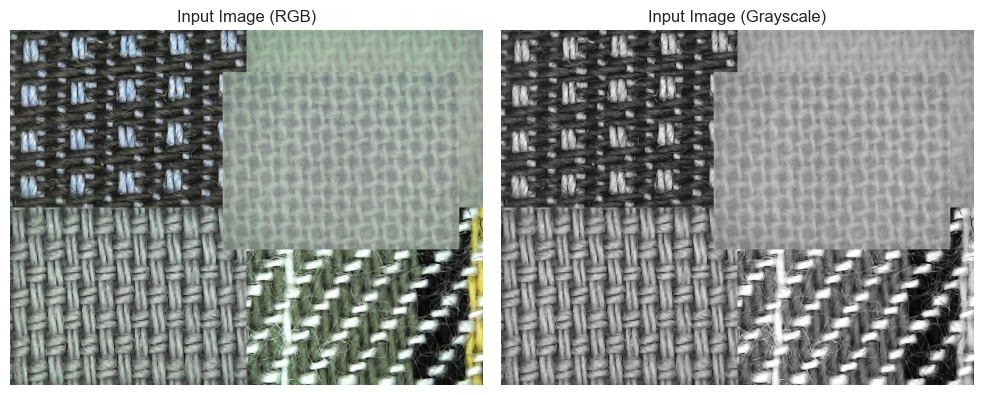


Attempting to load mask image from: .\mask.png

--- Mask Image ('mask.png') ---
Shape: (960, 1280, 3) (Height, Width, Channels)
Data type: uint8
Input and Mask image dimensions match.


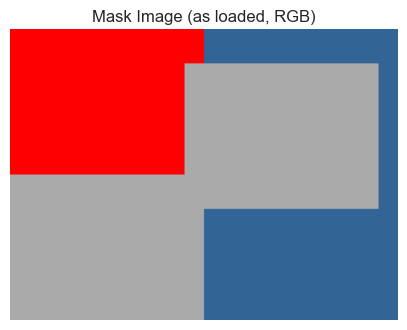


Found 11 unique colors in the mask image (these are our classes):
Class 0: RGB(np.uint8(50), np.uint8(100), np.uint8(150))
Class 1: RGB(np.uint8(85), np.uint8(120), np.uint8(156))
Class 2: RGB(np.uint8(96), np.uint8(127), np.uint8(157))
Class 3: RGB(np.uint8(106), np.uint8(133), np.uint8(160))
Class 4: RGB(np.uint8(124), np.uint8(143), np.uint8(162))
Class 5: RGB(np.uint8(140), np.uint8(153), np.uint8(165))
Class 6: RGB(np.uint8(170), np.uint8(170), np.uint8(170))
Class 7: RGB(np.uint8(202), np.uint8(105), np.uint8(105))
Class 8: RGB(np.uint8(234), np.uint8(43), np.uint8(43))
Class 9: RGB(np.uint8(242), np.uint8(26), np.uint8(26))
Class 10: RGB(np.uint8(255), np.uint8(0), np.uint8(0))


C:\Users\kerem\AppData\Local\Temp\ipykernel_14748\3463180584.py:85: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


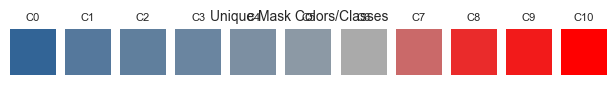


Processed Label Mask (single channel, integer labels):
Shape: (960, 1280)
Data type: uint8
Unique labels in processed mask: [ 0  1  2  3  4  5  6  7  8  9 10]


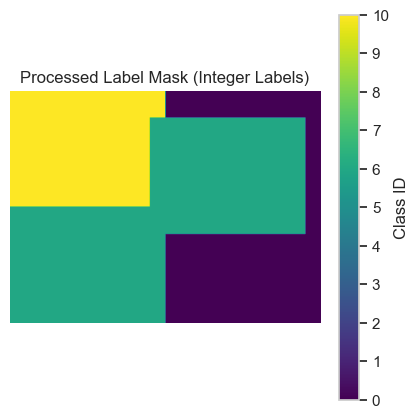


Number of classes identified from mask: 11


In [7]:
# Construct full file paths using the DATASET_DIR which is "."
input_image_path = os.path.join(DATASET_DIR, INPUT_IMAGE_NAME)
mask_image_path = os.path.join(DATASET_DIR, MASK_IMAGE_NAME)

# Initialize variables to None to handle potential FileNotFoundError gracefully
input_img_rgb = None
input_img_gray = None
mask_img_rgb = None
label_mask = None
N_CLASSES = 0
class_label_mapping = {}

# --- Load Input Image ---
try:
    print(f"Attempting to load input image from: {input_image_path}")
    input_img_bgr = cv2.imread(input_image_path) 
    if input_img_bgr is None:
        raise FileNotFoundError(f"Input image not found or could not be read: {input_image_path}")
    input_img_rgb = cv2.cvtColor(input_img_bgr, cv2.COLOR_BGR2RGB) 
    input_img_gray = cv2.cvtColor(input_img_bgr, cv2.COLOR_BGR2GRAY)
    
    print(f"--- Input Image ('{INPUT_IMAGE_NAME}') ---")
    print(f"Shape: {input_img_rgb.shape} (Height, Width, Channels)")
    print(f"Data type: {input_img_rgb.dtype}")
    print(f"Grayscale shape: {input_img_gray.shape}")

    plt.figure(figsize=(10, 5)) # Adjusted figure size
    plt.subplot(1, 2, 1)
    plt.imshow(input_img_rgb)
    plt.title("Input Image (RGB)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(input_img_gray, cmap='gray')
    plt.title("Input Image (Grayscale)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An error occurred while loading or processing the input image: {e}")


# --- Load Mask Image ---
if input_img_rgb is not None: # Proceed only if input image was loaded
    try:
        print(f"\nAttempting to load mask image from: {mask_image_path}")
        mask_img_bgr = cv2.imread(mask_image_path) 
        if mask_img_bgr is None:
            raise FileNotFoundError(f"Mask image not found or could not be read: {mask_image_path}")
        mask_img_rgb = cv2.cvtColor(mask_img_bgr, cv2.COLOR_BGR2RGB)

        print(f"\n--- Mask Image ('{MASK_IMAGE_NAME}') ---")
        print(f"Shape: {mask_img_rgb.shape} (Height, Width, Channels)")
        print(f"Data type: {mask_img_rgb.dtype}")

        # Verify mask dimensions match input image dimensions
        if input_img_rgb.shape[:2] != mask_img_rgb.shape[:2]:
            print(f"Error: Input image shape {input_img_rgb.shape[:2]} and Mask image shape {mask_img_rgb.shape[:2]} do not match!")
        else:
            print("Input and Mask image dimensions match.")

            plt.figure(figsize=(5, 5)) # Adjusted figure size
            plt.imshow(mask_img_rgb)
            plt.title("Mask Image (as loaded, RGB)")
            plt.axis('off')
            plt.show()

            pixels = mask_img_rgb.reshape(-1, 3)
            unique_colors_rgb = np.unique(pixels, axis=0)
            
            print(f"\nFound {len(unique_colors_rgb)} unique colors in the mask image (these are our classes):")
            color_patches_fig, color_axs = plt.subplots(1, len(unique_colors_rgb), figsize=(len(unique_colors_rgb) * 0.7, 0.7))
            if len(unique_colors_rgb) == 1: color_axs = [color_axs] # Ensure axs is iterable for 1 class

            for i, color in enumerate(unique_colors_rgb):
                class_label_mapping[tuple(color)] = i
                print(f"Class {i}: RGB{tuple(color)}")
                color_axs[i].imshow([[color/255.0]]) # imshow expects float 0-1 or int 0-255. Normalize if passing float.
                color_axs[i].set_title(f"C{i}", fontsize=8)
                color_axs[i].axis('off')
            plt.suptitle("Unique Mask Colors/Classes", fontsize=10, y=1.1) # Adjust y for suptitle position
            plt.tight_layout()
            plt.show()

            label_mask = np.zeros((mask_img_rgb.shape[0], mask_img_rgb.shape[1]), dtype=np.uint8)
            for i, color_rgb in enumerate(unique_colors_rgb):
                match = np.all(mask_img_rgb == color_rgb, axis=-1)
                label_mask[match] = i
                
            print("\nProcessed Label Mask (single channel, integer labels):")
            print(f"Shape: {label_mask.shape}")
            print(f"Data type: {label_mask.dtype}")
            print(f"Unique labels in processed mask: {np.unique(label_mask)}")
            
            plt.figure(figsize=(5, 5)) # Adjusted figure size
            plt.imshow(label_mask, cmap='viridis', vmin=0, vmax=len(unique_colors_rgb)-1) 
            plt.title("Processed Label Mask (Integer Labels)")
            plt.colorbar(ticks=np.unique(label_mask), label='Class ID')
            plt.axis('off')
            plt.show()
            
            N_CLASSES = len(unique_colors_rgb)
            print(f"\nNumber of classes identified from mask: {N_CLASSES}")

    except FileNotFoundError as e:
        print(e)
    except Exception as e:
        print(f"An error occurred while loading or processing the mask image: {e}")
else:
    print("Input image was not loaded, skipping mask image processing.")

---
**End of Stage 1: Preparation and Data Loading Completed.**

In this stage, the foundational steps for the texture image segmentation project were successfully executed on the local machine:

1.  **Library Imports:** Essential libraries for image processing (OpenCV, Scikit-image), data manipulation (NumPy, Pandas), machine learning (Scikit-learn), and visualization (Matplotlib, Seaborn) were imported. Crucially, CuPy was also imported and configured, confirming **GPU (NVIDIA GeForce RTX 3050 Laptop GPU) availability** for accelerated computations.
2.  **Global Constants:** Project-wide constants were defined, including `RANDOM_SEED=13`, the `DATASET_DIR="."` (indicating images are in the same directory as the notebook), image filenames (`input.png`, `mask.png`), and default sliding window parameters (10x10 window, stride 1).
3.  **Image Loading and Inspection:**
    *   The input texture image (`input.png`) was loaded (960x1280 pixels, 3 RGB channels). A grayscale version (`input_img_gray`) was also prepared, as many texture features are computed on single-channel images.
    *   The mask image (`mask.png`) was loaded (960x1280 pixels, 3 RGB channels).
    *   The dimensions of the input and mask images were verified to match.
4.  **Mask Processing and Class Identification:**
    *   Analysis of the `mask.png` revealed **11 unique RGB colors**, corresponding to **11 distinct texture classes**.
    *   A single-channel `label_mask` (960x1280, uint8) was generated by mapping each unique RGB color to an integer label (ranging from 0 to 10). This `label_mask` will provide the ground truth for training.
    *   The total number of classes (`N_CLASSES`) was confirmed to be 11.
---

---
## STAGE 2: FEATURE EXTRACTION SETUP (SLIDING WINDOW AND TEXTURE FEATURE FUNCTIONS)

This stage is dedicated to defining the mechanisms for extracting texture features from image patches (windows) and then setting up the sliding window process to generate our tabular dataset. We will aim to utilize CuPy for GPU acceleration where feasible to speed up computations.

**Key parts of this stage:**
1.  Define functions to calculate various texture features (e.g., statistical, GLCM, LBP, Gabor) from a given image patch, adapting them for potential CuPy usage.
2.  Define a main function that will iterate over the input image with a 2D sliding window, extract features for each window using the functions from step 1, and get the corresponding label from the mask.
---

### 2.1 Define Texture Feature Extraction Functions (CuPy Adapted)

Here, we will define functions to calculate texture features from image patches. We will use CuPy for GPU acceleration where it provides a clear benefit and is straightforward to implement. For some `scikit-image` functions that expect NumPy arrays, we might need to transfer data between CPU and GPU.

**Features to be implemented:**
-   Basic Statistical Features (Mean, Std, Var, Median, Min, Max) - *GPU adaptable with CuPy*
-   GLCM Features (Contrast, Dissimilarity, Homogeneity, Energy, Correlation, ASM) - *scikit-image (CPU), parameters simplified for speed*
-   LBP Features (Histogram of LBP codes) - *scikit-image (CPU for LBP image), histogram can be on GPU*
-   Gabor Filter Features (Mean, Std, Var of responses) - *OpenCV (CPU for convolution for now), stats can be on GPU. Kernel count simplified.*

In [10]:
# Ensure CUPY_AVAILABLE, np, cp are defined/imported from Cell 1.1

# --- 1. Basic Statistical Features (Optimized for CuPy) ---
def calculate_statistical_features_gpu_batch(patches_gpu):
    """
    Calculates statistical features for a batch of patches on the GPU.
    Args:
        patches_gpu (cp.ndarray): A 3D CuPy array of shape (num_patches, window_height, window_width).
    Returns:
        dict: A dictionary sintomas_nombre_feature: CuPy_array_of_values.
    """
    if not CUPY_AVAILABLE or not isinstance(patches_gpu, cp.ndarray):
        # Fallback or raise error if not on GPU, though this function is designed for GPU batch
        # For single patch CPU fallback, a different function or logic would be needed if called from non-GPU path
        print("Warning: calculate_statistical_features_gpu_batch called without CuPy or GPU array. Results might be slow or incorrect.")
        # Basic CPU fallback for a single patch if it somehow gets here (should not happen with current Cell 2.2 logic)
        if patches_gpu.ndim == 2: # single patch
            return {
                'stat_pixel_mean': np.mean(patches_gpu),
                'stat_pixel_std': np.std(patches_gpu),
                'stat_pixel_min': np.min(patches_gpu),
                'stat_pixel_max': np.max(patches_gpu)
            }
        else: # Cannot handle CPU batch with this simple fallback
            raise ValueError("Fallback for CPU batch not implemented in this simplified function.")

    # Calculate features across the patch dimensions (axis=(1,2)) for each patch
    # Ensure input is float for potentially better precision in mean/std
    patches_float_gpu = patches_gpu.astype(cp.float32) if patches_gpu.dtype != cp.float32 else patches_gpu
    
    features_batch = {
        'stat_pixel_mean': cp.mean(patches_float_gpu, axis=(1, 2)),
        'stat_pixel_std': cp.std(patches_float_gpu, axis=(1, 2)),
        'stat_pixel_min': cp.min(patches_float_gpu, axis=(1, 2)),
        'stat_pixel_max': cp.max(patches_float_gpu, axis=(1, 2))
        # 'stat_pixel_var': cp.var(patches_float_gpu, axis=(1, 2)), # Optional
        # 'stat_pixel_median': cp.median(patches_float_gpu, axis=(1,2)), # cp.median needs axis support & version
    }
    return features_batch

# --- GLCM, LBP, Gabor functions are TEMPORARILY DISABLED for speed test ---
# def calculate_glcm_features(patch_cpu_gray_uint8): ...
# def calculate_lbp_features(patch_cpu_gray, P=8, R=1): ...
# def calculate_gabor_features(patch_cpu_gray): ...
# print(f"Generated Gabor kernels (CPU version).") # This would also be disabled

print("\nSimplified helper functions for texture feature extraction defined (CuPy focused statistical).")
print("- calculate_statistical_features_gpu_batch (expects batched CuPy array)")
print("- GLCM, LBP, Gabor features are DISABLED for this run.")


Simplified helper functions for texture feature extraction defined (CuPy focused statistical).
- calculate_statistical_features_gpu_batch (expects batched CuPy array)
- GLCM, LBP, Gabor features are DISABLED for this run.


### 2.2 Sliding Window for Tabular Data Generation (CuPy Adapted)

This function will iterate over the input grayscale image with a 2D sliding window. For each window (patch):
1.  The patch will be transferred to the GPU if CuPy is available.
2.  Texture features will be extracted using the helper functions (some running on GPU, some on CPU with data transfer).
3.  The corresponding class label from the `label_mask` (also potentially on GPU) at the center of the window will be determined.
4.  Features and labels will be collected to form a Pandas DataFrame.

Progress tracking is included due to the potentially long processing time.

In [11]:
# Cell 2.2: Sliding Window for Tabular Data Generation (Using Simplified Features)

import time # Ensure time is imported

# Ensure input_img_gray, label_mask, DEFAULT_WINDOW_SIDE_LENGTH, STRIDE,
# CUPY_AVAILABLE, cp, and calculate_statistical_features_gpu_batch are available.

def generate_tabular_data_simplified(image_cpu_gray, mask_cpu_labels, window_size, stride):
    all_window_data_list = []
    img_height, img_width = image_cpu_gray.shape
    
    print(f"Starting SIMPLIFIED tabular data generation (only statistical features)...")
    print(f"Window_size={window_size}x{window_size}, stride={stride}")
    print(f"Image dimensions: Height={img_height}, Width={img_width}")
    print(f"CuPy Available: {CUPY_AVAILABLE}")

    num_windows_y = (img_height - window_size) // stride + 1
    num_windows_x = (img_width - window_size) // stride + 1
    total_windows = num_windows_y * num_windows_x
    print(f"Total windows to process: {total_windows}")
    
    if total_windows == 0:
        print("No windows to process.")
        return pd.DataFrame()

    processed_windows = 0
    start_time_total = time.time()
    report_interval_windows = max(1, total_windows // 100)

    # Prepare images on GPU if CuPy is available for label lookup
    mask_gpu_labels = None
    if CUPY_AVAILABLE:
        # input_img_gpu_gray = cp.asarray(image_cpu_gray) # We'll send patches instead of whole image
        mask_gpu_labels = cp.asarray(mask_cpu_labels)

    for y in range(0, img_height - window_size + 1, stride):
        for x in range(0, img_width - window_size + 1, stride):
            patch_cpu = image_cpu_gray[y : y + window_size, x : x + window_size]
            
            if patch_cpu.shape[0] != window_size or patch_cpu.shape[1] != window_size:
                continue

            # --- 1. Extract ONLY Statistical Features ---
            # For calculate_statistical_features_gpu_batch, we need to pass a "batch" of 1 patch
            # Reshape patch_cpu to (1, window_size, window_size) before sending to the batch function
            # or modify the function to handle single patches directly if CUPY_AVAILABLE.
            # Let's modify the stat function to handle single CPU patch and convert internally.
            
            # Re-defining a simpler stat function for this specific loop structure:
            current_features = {}
            if CUPY_AVAILABLE:
                patch_gpu = cp.asarray(patch_cpu, dtype=cp.float32)
                current_features['stat_pixel_mean'] = cp.mean(patch_gpu).item()
                current_features['stat_pixel_std'] = cp.std(patch_gpu).item()
                current_features['stat_pixel_min'] = cp.min(patch_gpu).item()
                current_features['stat_pixel_max'] = cp.max(patch_gpu).item()
            else: # Fallback to NumPy
                current_features['stat_pixel_mean'] = np.mean(patch_cpu)
                current_features['stat_pixel_std'] = np.std(patch_cpu)
                current_features['stat_pixel_min'] = np.min(patch_cpu)
                current_features['stat_pixel_max'] = np.max(patch_cpu)

            # --- Other feature types (GLCM, LBP, Gabor) are SKIPPED ---

            # --- 2. Get the Label ---
            center_y = y + window_size // 2
            center_x = x + window_size // 2
            if CUPY_AVAILABLE and mask_gpu_labels is not None:
                label = mask_gpu_labels[center_y, center_x].item()
            else:
                label = mask_cpu_labels[center_y, center_x]
            current_features['target_label'] = label
            
            all_window_data_list.append(current_features)
            
            processed_windows += 1
            if processed_windows % report_interval_windows == 0 or processed_windows == total_windows:
                current_time = time.time()
                elapsed_total = current_time - start_time_total
                avg_time_per_window_total = elapsed_total / processed_windows if processed_windows > 0 else 0
                estimated_total_time = avg_time_per_window_total * total_windows if avg_time_per_window_total > 0 else 0
                remaining_time = estimated_total_time - elapsed_total
                percent_complete = (processed_windows / total_windows) * 100
                
                print(f"  Processed {processed_windows}/{total_windows} windows ({percent_complete:.1f}%) | "
                      f"Elapsed: {elapsed_total:.0f}s | "
                      f"Est. Remaining: {max(0, remaining_time):.0f}s | "
                      f"Avg time/window: {avg_time_per_window_total*1000:.2f} ms")
                 
    print(f"\nFinished processing all {processed_windows} windows.")
    elapsed_final = time.time() - start_time_total
    print(f"Total processing time for SIMPLIFIED features: {elapsed_final // 60:.0f} minutes {elapsed_final % 60:.0f} seconds.")
    
    if not all_window_data_list:
        print("Warning: No window data was generated.")
        return pd.DataFrame()
        
    return pd.DataFrame(all_window_data_list)

# --- Generate the tabular data ---
if 'input_img_gray' not in locals() or input_img_gray is None or \
   'label_mask' not in locals() or label_mask is None:
    print("Error: input_img_gray or label_mask is not available. Please ensure Stage 1 (Cell 1.3) ran successfully.")
    df_tabular_data = pd.DataFrame()
else:
    df_tabular_data = generate_tabular_data_simplified( # Using the new simplified function name
        input_img_gray, 
        label_mask, 
        window_size=DEFAULT_WINDOW_SIDE_LENGTH, 
        stride=STRIDE
    )

    if not df_tabular_data.empty:
        print("\n--- Generated Tabular Data (df_tabular_data with SIMPLIFIED features) ---")
        print(f"Shape of the tabular DataFrame: {df_tabular_data.shape}") # Should have fewer feature columns
        print("First 5 rows:")
        display(df_tabular_data.head())
        print("\nInfo:")
        df_tabular_data.info(verbose=False, max_cols=10)
        print("\nClass distribution in 'target_label':")
        display(df_tabular_data['target_label'].value_counts(normalize=True).sort_index())
        
        feature_cols_for_nan_check = [col for col in df_tabular_data.columns if col != 'target_label']
        if feature_cols_for_nan_check: # Check if there are feature columns
            nan_feature_counts = df_tabular_data[feature_cols_for_nan_check].isnull().sum()
            nan_feature_cols = nan_feature_counts[nan_feature_counts > 0]
            if not nan_feature_cols.empty:
                print("\nFeatures with NaN values and their counts:")
                print(nan_feature_cols)
            else:
                print("\nNo NaN values found in extracted features.")
        else:
            print("\nNo feature columns found to check for NaNs (excluding target_label).")

    else:
        print("Tabular data generation resulted in an empty DataFrame.")

Starting SIMPLIFIED tabular data generation (only statistical features)...
Window_size=10x10, stride=1
Image dimensions: Height=960, Width=1280
CuPy Available: True
Total windows to process: 1208721
  Processed 12087/1208721 windows (1.0%) | Elapsed: 6s | Est. Remaining: 591s | Avg time/window: 0.49 ms
  Processed 24174/1208721 windows (2.0%) | Elapsed: 12s | Est. Remaining: 581s | Avg time/window: 0.49 ms
  Processed 36261/1208721 windows (3.0%) | Elapsed: 18s | Est. Remaining: 576s | Avg time/window: 0.49 ms
  Processed 48348/1208721 windows (4.0%) | Elapsed: 24s | Est. Remaining: 572s | Avg time/window: 0.49 ms
  Processed 60435/1208721 windows (5.0%) | Elapsed: 30s | Est. Remaining: 567s | Avg time/window: 0.49 ms
  Processed 72522/1208721 windows (6.0%) | Elapsed: 36s | Est. Remaining: 560s | Avg time/window: 0.49 ms
  Processed 84609/1208721 windows (7.0%) | Elapsed: 42s | Est. Remaining: 554s | Avg time/window: 0.49 ms
  Processed 96696/1208721 windows (8.0%) | Elapsed: 48s | Es

,stat_pixel_mean,stat_pixel_std,stat_pixel_min,stat_pixel_max,target_label
0,78.740,8.083,50.000,96.000,10
1,78.910,8.135,61.000,97.000,10
2,78.970,8.729,61.000,100.000,10
3,78.970,9.494,61.000,100.000,10
4,78.760,10.650,55.000,100.000,10



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208721 entries, 0 to 1208720
Columns: 5 entries, stat_pixel_mean to target_label
dtypes: float64(4), int64(1)
memory usage: 46.1 MB

Class distribution in 'target_label':


target_label
0    0.271
1    0.000
2    0.000
3    0.000
4    0.000
5    0.000
6    0.497
7    0.000
8    0.000
9    0.000
10   0.230
Name: proportion, dtype: float64


No NaN values found in extracted features.


In [12]:
if 'df_tabular_data' in locals() and not df_tabular_data.empty:
    print("Actual counts for each class in 'target_label':")
    print(df_tabular_data['target_label'].value_counts().sort_index())
else:
    print("df_tabular_data is not available.")

Actual counts for each class in 'target_label':
target_label
0     327780
1          1
2        575
3          1
4        575
5        479
6     601109
7         64
8        366
9          1
10    277770
Name: count, dtype: int64


In [13]:
# Cell 2.2.1: Clean Target Labels (Remove classes with very few samples)

if 'df_tabular_data' in locals() and not df_tabular_data.empty:
    print("Original class distribution (counts):")
    original_counts = df_tabular_data['target_label'].value_counts().sort_index()
    display(original_counts)

    # Identify classes with very few samples (e.g., <= 1 or a small threshold)
    min_samples_threshold = 2 # Classes with 1 or fewer samples will be removed
    # Or you can define a slightly higher threshold if classes like '7' (64 samples) are also problematic
    # For now, let's stick to removing only those with 1 sample.
    
    value_counts = df_tabular_data['target_label'].value_counts()
    labels_to_remove = value_counts[value_counts <= 1].index.tolist() # Get labels of classes with <=1 sample

    if labels_to_remove:
        print(f"\nRemoving classes with <= 1 sample: {labels_to_remove}")
        df_tabular_data_cleaned = df_tabular_data[~df_tabular_data['target_label'].isin(labels_to_remove)].copy()
        
        # It's good practice to re-map the remaining labels to be contiguous (0, 1, 2, ...)
        # if some labels in the middle were removed.
        # However, if we only remove a few and the remaining labels are not too sparse,
        # scikit-learn models can handle non-contiguous integer labels.
        # For simplicity now, let's see the new distribution.
        # If needed, we can remap later.
        
        print("\nClass distribution after removing very small classes (counts):")
        new_counts = df_tabular_data_cleaned['target_label'].value_counts().sort_index()
        display(new_counts)
        print(f"Number of samples before cleaning: {len(df_tabular_data)}")
        print(f"Number of samples after cleaning: {len(df_tabular_data_cleaned)}")
        print(f"Number of classes remaining: {df_tabular_data_cleaned['target_label'].nunique()}")
        
        # Update N_CLASSES if it's used later (it was defined from unique_colors_rgb)
        # N_CLASSES_updated = df_tabular_data_cleaned['target_label'].nunique()
        # print(f"Updated number of classes for modeling: {N_CLASSES_updated}")
        
        # Replace the original df_tabular_data with the cleaned one
        df_tabular_data = df_tabular_data_cleaned
    else:
        print("\nNo classes found with <= 1 sample to remove.")
else:
    print("df_tabular_data is not available for cleaning.")

Original class distribution (counts):


target_label
0     327780
1          1
2        575
3          1
4        575
5        479
6     601109
7         64
8        366
9          1
10    277770
Name: count, dtype: int64


Removing classes with <= 1 sample: [9, 3, 1]

Class distribution after removing very small classes (counts):


target_label
0     327780
2        575
4        575
5        479
6     601109
7         64
8        366
10    277770
Name: count, dtype: int64

Number of samples before cleaning: 1208721
Number of samples after cleaning: 1208718
Number of classes remaining: 8


### 2.3 Save the Generated Tabular Data

After generating and cleaning the tabular data (removing classes with very few samples), we will save it to a CSV file. This will allow us to load it directly in future sessions without re-running the time-consuming feature extraction process.

In [14]:
if 'df_tabular_data' in locals() and not df_tabular_data.empty:
    # Define the filename for the saved tabular data
    tabular_data_filename = "texture_tabular_features_ws" + str(DEFAULT_WINDOW_SIDE_LENGTH) + "_simplified.csv"
    tabular_data_path = os.path.join(DATASET_DIR, tabular_data_filename)

    try:
        df_tabular_data.to_csv(tabular_data_path, index=False)
        print(f"\nCleaned tabular data saved successfully to: {tabular_data_path}")
        print(f"Saved data shape: {df_tabular_data.shape}")
        print(f"Number of unique classes in saved data: {df_tabular_data['target_label'].nunique()}")
    except Exception as e:
        print(f"\nError saving the tabular data: {e}")
else:
    print("No tabular data available to save (df_tabular_data is empty or not defined).")

# Update N_CLASSES global variable based on the cleaned data
if 'df_tabular_data' in locals() and not df_tabular_data.empty and 'target_label' in df_tabular_data.columns:
    N_CLASSES_FINAL = df_tabular_data['target_label'].nunique()
    print(f"\nFinal number of classes for modeling: {N_CLASSES_FINAL}")
else:
    N_CLASSES_FINAL = 0 # Or handle as an error
    print("\nCould not determine final number of classes.")


Cleaned tabular data saved successfully to: .\texture_tabular_features_ws10_simplified.csv
Saved data shape: (1208718, 5)
Number of unique classes in saved data: 8

Final number of classes for modeling: 8


---
## STAGE 3: TABULAR DATA EXPLORATION AND PREPROCESSING

Now that we have generated the tabular dataset (`df_tabular_data`) with simplified texture features, we will perform Exploratory Data Analysis (EDA) on this new dataset and prepare it for model training.

**Key tasks in this stage:**
1.  Perform a general overview of `df_tabular_data` (info, describe, check for NaNs again).
2.  Analyze the distribution of the extracted texture features.
3.  Examine correlations between features.
4.  Confirm the class distribution of the `target_label`.
---

### 3.1 Overview of the Generated Tabular Data

Let's inspect the `df_tabular_data` DataFrame that we created.

In [15]:
# Ensure df_tabular_data is available from Stage 2
if 'df_tabular_data' not in locals() or df_tabular_data.empty:
    print("Error: df_tabular_data is not available. Attempting to load from saved CSV...")
    tabular_data_filename = "texture_tabular_features_ws" + str(DEFAULT_WINDOW_SIDE_LENGTH) + "_simplified.csv"
    tabular_data_path = os.path.join(DATASET_DIR, tabular_data_filename)
    try:
        df_tabular_data = pd.read_csv(tabular_data_path)
        print(f"Successfully loaded df_tabular_data from {tabular_data_path}")
        # N_CLASSES_FINAL might need to be redefined if loading fresh
        if 'target_label' in df_tabular_data.columns:
             N_CLASSES_FINAL = df_tabular_data['target_label'].nunique()
             print(f"Number of classes from loaded file: {N_CLASSES_FINAL}")
        else:
            print("Warning: 'target_label' not found in loaded CSV.")
            N_CLASSES_FINAL = 0 # Default if not found
    except FileNotFoundError:
        print(f"Error: Could not load {tabular_data_path}. Please ensure Stage 2 ran and the file was saved.")
        # df_tabular_data = pd.DataFrame() # Critical error, stop or handle
    except Exception as e:
        print(f"An error occurred while loading the CSV: {e}")
        # df_tabular_data = pd.DataFrame()

if 'df_tabular_data' in locals() and not df_tabular_data.empty:
    print("\n--- Overview of Tabular Data (df_tabular_data) ---")
    print(f"Shape: {df_tabular_data.shape}")
    print("\nFirst 5 rows:")
    display(df_tabular_data.head())
    
    print("\nInfo:")
    df_tabular_data.info() # verbose=True to see all columns, but we only have a few features now
    
    print("\nDescriptive statistics for features:")
    # Exclude target_label for describe on features
    feature_columns = [col for col in df_tabular_data.columns if col != 'target_label']
    if feature_columns:
        display(df_tabular_data[feature_columns].describe())
    else:
        print("No feature columns found to describe (excluding target_label).")
        
    print("\nClass distribution (target_label) - Counts:")
    display(df_tabular_data['target_label'].value_counts().sort_index())
    print("\nClass distribution (target_label) - Proportions:")
    display(df_tabular_data['target_label'].value_counts(normalize=True).sort_index())

    # Final check for NaNs in the entire DataFrame
    if df_tabular_data.isnull().sum().sum() > 0:
        print("\nWarning: NaN values detected in df_tabular_data:")
        print(df_tabular_data.isnull().sum()[df_tabular_data.isnull().sum() > 0])
    else:
        print("\nNo NaN values detected in df_tabular_data.")
else:
    print("\nCannot proceed with EDA as df_tabular_data is not available.")


--- Overview of Tabular Data (df_tabular_data) ---
Shape: (1208718, 5)

First 5 rows:


,stat_pixel_mean,stat_pixel_std,stat_pixel_min,stat_pixel_max,target_label
0,78.740,8.083,50.000,96.000,10
1,78.910,8.135,61.000,97.000,10
2,78.970,8.729,61.000,100.000,10
3,78.970,9.494,61.000,100.000,10
4,78.760,10.650,55.000,100.000,10



Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1208718 entries, 0 to 1208720
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   stat_pixel_mean  1208718 non-null  float64
 1   stat_pixel_std   1208718 non-null  float64
 2   stat_pixel_min   1208718 non-null  float64
 3   stat_pixel_max   1208718 non-null  float64
 4   target_label     1208718 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 55.3 MB

Descriptive statistics for features:


,stat_pixel_mean,stat_pixel_std,stat_pixel_min,stat_pixel_max
count,1208718.000,1208718.000,1208718.000,1208718.000
mean,128.250,19.905,83.658,166.024
std,48.215,14.382,57.493,46.008
min,4.270,0.467,0.000,11.000
25%,88.670,8.586,29.000,143.000
50%,141.460,15.794,78.000,175.000
75%,164.290,27.810,138.000,192.000
max,253.220,104.476,252.000,255.000



Class distribution (target_label) - Counts:


target_label
0     327780
2        575
4        575
5        479
6     601109
7         64
8        366
10    277770
Name: count, dtype: int64


Class distribution (target_label) - Proportions:


target_label
0    0.271
2    0.000
4    0.000
5    0.000
6    0.497
7    0.000
8    0.000
10   0.230
Name: proportion, dtype: float64


No NaN values detected in df_tabular_data.


### 3.2 Feature Distribution and Correlation Analysis

Let's visualize the distributions of our extracted statistical features and examine their correlations.


--- Distributions of Extracted Features ---


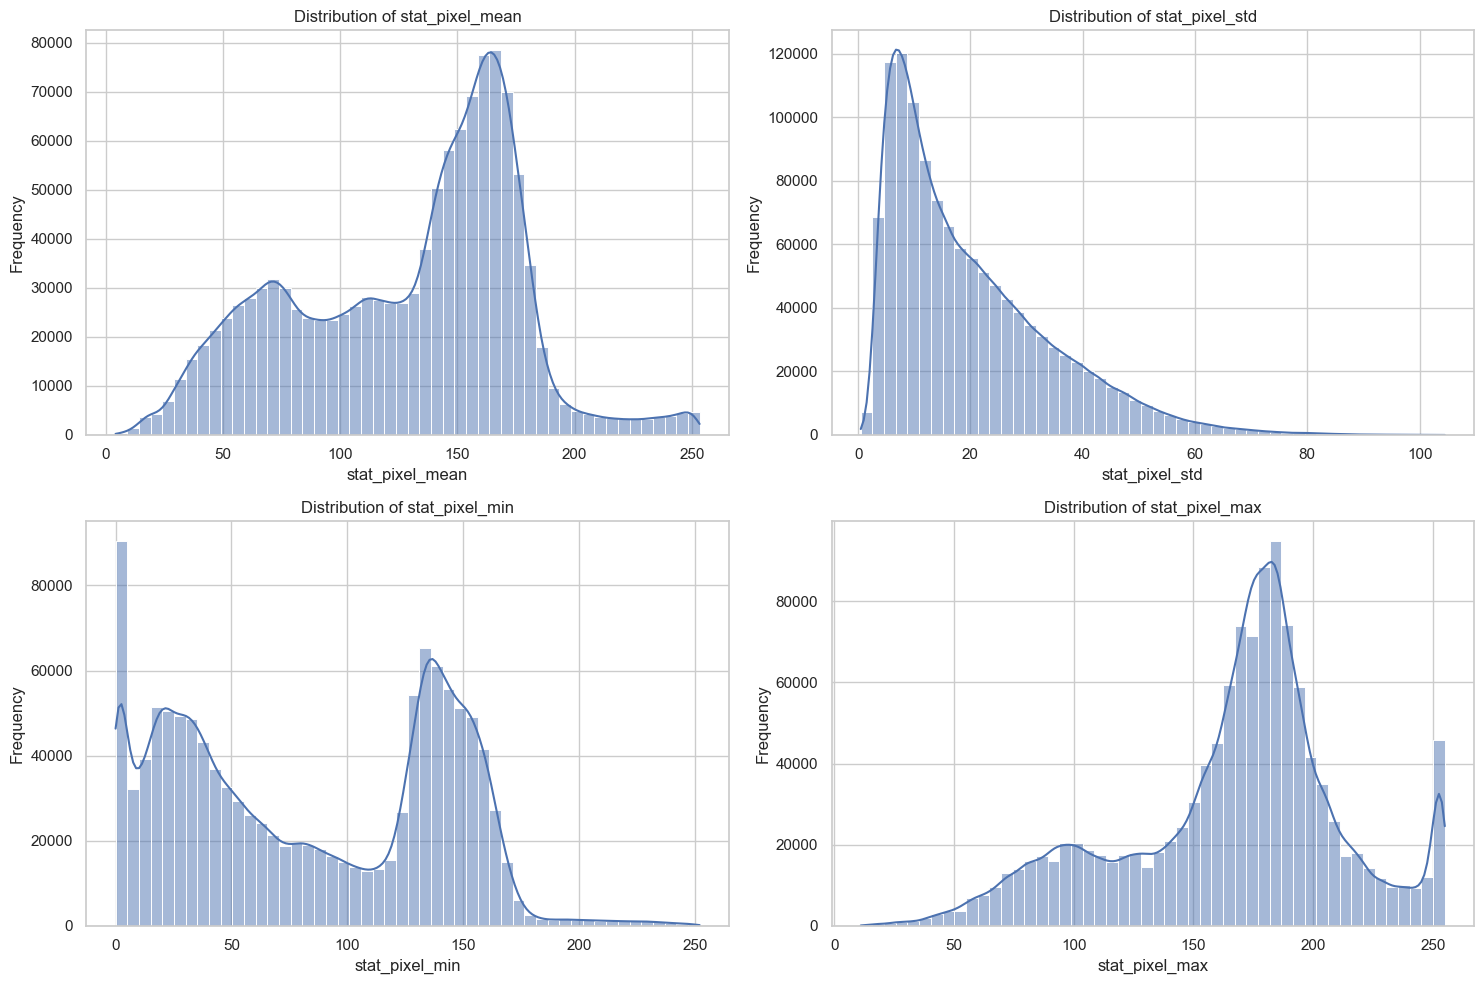


--- Correlation Matrix of Features ---


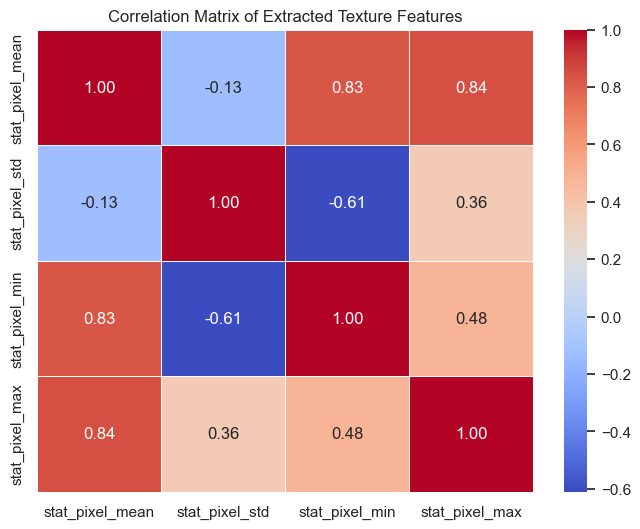

In [16]:
if 'df_tabular_data' in locals() and not df_tabular_data.empty:
    feature_columns = [col for col in df_tabular_data.columns if col != 'target_label']

    if not feature_columns:
        print("No feature columns found in df_tabular_data (excluding target_label).")
    else:
        # 1. Plot distributions of features
        print("\n--- Distributions of Extracted Features ---")
        plt.figure(figsize=(15, 10)) # Adjust as needed
        for i, col in enumerate(feature_columns):
            plt.subplot(2, 2, i + 1) # Assuming 4 features, creating a 2x2 grid
            sns.histplot(df_tabular_data[col], kde=True, bins=50)
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

        # 2. Plot correlation heatmap of features
        print("\n--- Correlation Matrix of Features ---")
        correlation_matrix_features = df_tabular_data[feature_columns].corr()
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix_features, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Extracted Texture Features')
        plt.show()
else:
    print("df_tabular_data is not available for analysis.")

---
**End of Stage 3: Tabular Data Exploration and Preprocessing Completed.**

Following the generation of tabular data (`df_tabular_data`) from the sliding window process with simplified statistical features, an Exploratory Data Analysis (EDA) was performed:

1.  **Data Overview (Cell 3.1):**
    *   The tabular dataset consists of **1,208,718 samples (windows)** and **5 columns** (4 statistical features: `stat_pixel_mean`, `stat_pixel_std`, `stat_pixel_min`, `stat_pixel_max`, and 1 `target_label`).
    *   All features are `float64` and the target is `int64`.
    *   Crucially, **no NaN values** were detected in the entire DataFrame.
    *   A significant **class imbalance** was confirmed for the 8 remaining classes, with classes 0, 6, and 10 being dominant.
2.  **Feature Distribution Analysis (Cell 3.2):**
    *   Histograms showed that `stat_pixel_mean`, `stat_pixel_min`, and `stat_pixel_max` exhibit **multimodal distributions**, suggesting these features vary distinctively across different texture types (windows).
    *   `stat_pixel_std` showed a **right-skewed distribution**, indicating most windows have lower standard deviation (less texture/contrast) but some have significantly higher values.
3.  **Feature Correlation Analysis (Cell 3.2):**
    *   A heatmap revealed moderate to strong positive correlations between `stat_pixel_mean` and both `stat_pixel_min` (0.83) and `stat_pixel_max` (0.84).
    *   A moderate negative correlation was observed between `stat_pixel_min` and `stat_pixel_std` (-0.61).
    *   Other correlations were weaker. While some correlation exists, the features are not perfectly redundant, and all four will be retained for initial modeling.
---

---
## STAGE 4: DATA SPLITTING AND FEATURE SCALING (for Tabular Texture Data)

With our tabular dataset (`df_tabular_data`) prepared, containing statistical texture features for each window, we now need to:
1.  Separate the features (X) from the target class labels (y).
2.  Split the dataset into training and testing sets (80% train, 20% test) using stratification to maintain class proportions, with `random_state=13`.
3.  Apply feature scaling (e.g., `StandardScaler`) to the numerical features. The scaler will be fitted **only** on the training data and then used to transform both training and testing data.
---

### 4.1 Separate Features (X) and Target (y)

We will define our feature matrix `X` (independent variables) and target vector `y` (dependent variable - the texture class labels) from the `df_tabular_data` DataFrame.

In [17]:
# Ensure df_tabular_data is available from Stage 3 (or loaded from CSV if notebook was restarted)
if 'df_tabular_data' not in locals() or df_tabular_data.empty:
    print("Error: df_tabular_data is not available. Please ensure Stage 2/3 ran successfully or load the CSV.")
    # df_tabular_data = pd.DataFrame() # Or load from CSV as in Cell 3.1 if needed
else:
    # Define the target variable
    y = df_tabular_data['target_label']

    # Define the features (X) by dropping the target column
    X = df_tabular_data.drop(columns=['target_label'])

    print("Features (X) and target (y) have been separated.")
    print(f"Shape of X: {X.shape}") # Should be (1208718, 4)
    print(f"Shape of y: {y.shape}") # Should be (1208718,)
    print("\nFirst 5 rows of X:")
    display(X.head())
    print("\nFirst 5 values of y:")
    display(y.head())

Features (X) and target (y) have been separated.
Shape of X: (1208718, 4)
Shape of y: (1208718,)

First 5 rows of X:


,stat_pixel_mean,stat_pixel_std,stat_pixel_min,stat_pixel_max
0,78.740,8.083,50.000,96.000
1,78.910,8.135,61.000,97.000
2,78.970,8.729,61.000,100.000
3,78.970,9.494,61.000,100.000
4,78.760,10.650,55.000,100.000



First 5 values of y:


0    10
1    10
2    10
3    10
4    10
Name: target_label, dtype: int64

### 4.2 Split Data into Training and Testing Sets

We will split `X` and `y` into training and testing sets.
- Test size: 20% (0.20)
- Training size: 80%
- `random_state`: 13 (for reproducibility)
- `stratify`: `y` (to ensure class proportions are maintained in both splits, crucial due to significant class imbalance)

In [18]:
from sklearn.model_selection import train_test_split

if 'X' not in locals() or 'y' not in locals() or X.empty:
    print("Error: X or y is not defined or X is empty. Please run Cell 4.1 first.")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.20,
        random_state=RANDOM_SEED, # Defined in Cell 1.2 (should be 13)
        stratify=y 
    )

    print("Data has been split into training and testing sets.")
    print(f"Shape of X_train: {X_train.shape}") # e.g., (1208718*0.8, 4) -> (~966974, 4)
    print(f"Shape of X_test: {X_test.shape}")   # e.g., (1208718*0.2, 4) -> (~241744, 4)
    print(f"Shape of y_train: {y_train.shape}")
    print(f"Shape of y_test: {y_test.shape}")

    print("\nClass distribution in original y (proportions):")
    print(y.value_counts(normalize=True).sort_index())
    print("\nClass distribution in y_train (proportions):")
    print(y_train.value_counts(normalize=True).sort_index())
    print("\nClass distribution in y_test (proportions):")
    print(y_test.value_counts(normalize=True).sort_index())
    print("\n(Distributions should be very similar due to stratification)")

Data has been split into training and testing sets.
Shape of X_train: (966974, 4)
Shape of X_test: (241744, 4)
Shape of y_train: (966974,)
Shape of y_test: (241744,)

Class distribution in original y (proportions):
target_label
0    0.271
2    0.000
4    0.000
5    0.000
6    0.497
7    0.000
8    0.000
10   0.230
Name: proportion, dtype: float64

Class distribution in y_train (proportions):
target_label
0    0.271
2    0.000
4    0.000
5    0.000
6    0.497
7    0.000
8    0.000
10   0.230
Name: proportion, dtype: float64

Class distribution in y_test (proportions):
target_label
0    0.271
2    0.000
4    0.000
5    0.000
6    0.497
7    0.000
8    0.000
10   0.230
Name: proportion, dtype: float64

(Distributions should be very similar due to stratification)


### 4.3 Feature Scaling

Our extracted statistical features are on different scales. We will use `StandardScaler` to standardize them by removing the mean and scaling to unit variance.
The `StandardScaler` will be **fitted ONLY on the training data (`X_train`)** and then `transform` will be applied to both `X_train` and `X_test`.

In [19]:
from sklearn.preprocessing import StandardScaler

if 'X_train' not in locals() or X_train.empty:
    print("Error: X_train is not defined or is empty. Please run Cell 4.2 first.")
else:
    scaler_texture = StandardScaler() # Using a new scaler name to avoid conflict with previous projects if in same notebook session

    # Fit the scaler ONLY on the training data's features
    X_train_scaled = scaler_texture.fit_transform(X_train)

    # Apply the SAME fitted scaler to transform the test data's features
    X_test_scaled = scaler_texture.transform(X_test)

    # Convert scaled NumPy arrays back to DataFrames with original column names and indices
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    print("Features have been scaled using StandardScaler.")
    print("Scaler was fit on X_train and used to transform X_train and X_test.")

    print("\nFirst 5 rows of scaled X_train (X_train_scaled_df.head()):")
    display(X_train_scaled_df.head())

    print("\nDescriptive statistics of scaled X_train (mean and std should be close to 0 and 1):")
    display(X_train_scaled_df.describe().loc[['mean', 'std']])

    print("\nFirst 5 rows of scaled X_test (X_test_scaled_df.head()):")
    display(X_test_scaled_df.head())

    print("\nDescriptive statistics of scaled X_test (mean and std will NOT be exactly 0 and 1):")
    display(X_test_scaled_df.describe().loc[['mean', 'std']])
    
    # No zero-variance feature removal step is explicitly planned here,
    # as the 4 statistical features are unlikely to have zero variance across ~1M samples.
    # If any were found, a VarianceThreshold step could be added like in Project 2.
    # For now, we assume all 4 features are informative.

Features have been scaled using StandardScaler.
Scaler was fit on X_train and used to transform X_train and X_test.

First 5 rows of scaled X_train (X_train_scaled_df.head()):


,stat_pixel_mean,stat_pixel_std,stat_pixel_min,stat_pixel_max
400895,0.651,0.868,-0.203,0.934
291695,0.782,-0.645,1.032,0.303
1194513,-0.601,-0.261,-0.429,-0.566
548165,-1.665,-0.501,-1.055,-1.762
281244,-0.370,1.899,-1.403,0.825



Descriptive statistics of scaled X_train (mean and std should be close to 0 and 1):


,stat_pixel_mean,stat_pixel_std,stat_pixel_min,stat_pixel_max
mean,-0.000,0.000,-0.000,-0.000
std,1.000,1.000,1.000,1.000



First 5 rows of scaled X_test (X_test_scaled_df.head()):


,stat_pixel_mean,stat_pixel_std,stat_pixel_min,stat_pixel_max
159563,0.276,-0.711,0.771,-0.066
55986,1.351,0.128,0.945,1.304
165927,0.546,-0.822,0.927,-0.001
1062204,-0.756,0.291,-0.760,-0.675
858996,-0.989,-0.407,-0.534,-1.219



Descriptive statistics of scaled X_test (mean and std will NOT be exactly 0 and 1):


,stat_pixel_mean,stat_pixel_std,stat_pixel_min,stat_pixel_max
mean,-0.002,-0.000,-0.002,-0.003
std,1.001,0.999,0.999,1.002


---
**End of Stage 4: Data Splitting and Feature Scaling Completed.**

In this stage, the tabular data (`df_tabular_data`) generated from texture features was prepared for classification model training:

1.  **Separated Features and Target (Cell 4.1):**
    *   The `df_tabular_data` (1,208,718 samples, 5 columns) was successfully separated into a feature matrix `X` (containing 4 statistical texture features: `stat_pixel_mean`, `stat_pixel_std`, `stat_pixel_min`, `stat_pixel_max`) and a target vector `y` (the `target_label` representing 8 distinct texture classes after cleaning).
2.  **Train-Test Split (Cell 4.2):**
    *   The dataset was split into training (80%) and testing (20%) sets using `random_state=13`.
    *   Crucially, `stratify=y` was employed to ensure that the significant class imbalance observed in the target variable was proportionally maintained in both the training set (966,974 samples) and the test set (241,744 samples).
3.  **Feature Scaling (Cell 4.3):**
    *   `StandardScaler` was used to standardize the 4 numerical features.
    *   The scaler was **fitted exclusively on `X_train`** and then applied to transform both `X_train` and `X_test`.
    *   The scaled training data (`X_train_scaled_df`) exhibited means of approximately 0 and standard deviations of approximately 1 for all features.
    *   The scaled test data (`X_test_scaled_df`) was transformed using the same scaler, with its feature statistics appropriately differing slightly from the ideal 0 mean and 1 std.
---

---
## STAGE 5: MODEL TRAINING, SELECTION, AND EVALUATION (CLASSIFICATION)

In this stage, we will train multiple classification models to predict the texture class for each image window. Their performance will be evaluated using stratified K-fold cross-validation on the training data (`X_train_scaled_df`, `y_train`). The primary metric for model selection and ranking will be **Intersection over Union (IoU)**, also known as the Jaccard Index. We will also consider accuracy, F1-score, precision, recall, training time, and test time. The best model will then be evaluated on the unseen test set (`X_test_scaled_df`, `y_test`) and saved.

**Key metrics for comparison (as per instructions):** IoU (Jaccard Score), Training Time, and Test Time (inference time).
---

### 5.1 Import Models, Metrics, and Cross-Validation Strategy

Import necessary classification models, the `jaccard_score` (for IoU), other relevant metrics, and `StratifiedKFold`.

In [20]:
import time
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, jaccard_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Classification Models were already imported in Cell 1.1:
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# For saving the model (already imported)
# import joblib

# Ensure our final training and test sets are available from Stage 4
if 'X_train_scaled_df' not in locals() or 'y_train' not in locals() or \
   'X_test_scaled_df' not in locals() or 'y_test' not in locals() or X_train_scaled_df.empty:
    print("Error: Scaled training/testing data not found or X_train_scaled_df is empty. Please ensure Stage 4 was run successfully.")
else:
    print("Scaled training and testing data are available for model training.")
    print(f"X_train_scaled_df shape: {X_train_scaled_df.shape}, y_train shape: {y_train.shape}")
    print(f"X_test_scaled_df shape: {X_test_scaled_df.shape}, y_test shape: {y_test.shape}")

# Define the number of folds for cross-validation
# Given the large number of samples (~967k in training), 5 folds should be sufficient and faster than 10.
N_SPLITS_CV_TEXTURE = 5 
# RANDOM_SEED is already defined (e.g., 13)

# Define IoU (Jaccard Score) scorer. For multi-class, 'weighted' or 'macro' average is common.
# 'macro' calculates metrics for each label, and find their unweighted mean.
# 'weighted' calculates metrics for each label, and find their average weighted by support.
# Given the class imbalance, 'weighted' IoU might be more representative of overall performance.
# However, if all classes are equally important regardless of size, 'macro' is better.
# Let's use 'macro' for IoU as it treats all classes equally, which is often desired for segmentation quality.
# If a class has 0 true positives and 0 false positives for a given fold, Jaccard score is 0.
# If a class has 0 true positives but some false positives/negatives, Jaccard is 0.
# If a class is not present in y_true for a fold, its Jaccard is typically not included in macro avg unless labels are specified.
# We will handle labels within the loop.
iou_scorer = make_scorer(jaccard_score, average='macro', zero_division=0)
# Also define for weighted, to see the difference
iou_scorer_weighted = make_scorer(jaccard_score, average='weighted', zero_division=0)


print(f"\nUsing Stratified {N_SPLITS_CV_TEXTURE}-Fold Cross-Validation.")
print(f"Primary evaluation metric: IoU (Jaccard Score, macro average). Weighted IoU will also be calculated.")

Scaled training and testing data are available for model training.
X_train_scaled_df shape: (966974, 4), y_train shape: (966974,)
X_test_scaled_df shape: (241744, 4), y_test shape: (241744,)

Using Stratified 5-Fold Cross-Validation.
Primary evaluation metric: IoU (Jaccard Score, macro average). Weighted IoU will also be calculated.


### 5.2 Define Models and Perform Cross-Validation

We will define a list of classification models. Then, using `cross_validate` with `StratifiedKFold`, we'll evaluate each model based on IoU, accuracy, F1-score (weighted), and timings.
Due to the large dataset size, some models like SVC with non-linear kernels might be slow. We might use a subset of data for SVC or simplify its parameters if it takes too long.

In [21]:
# Define models to evaluate (using mostly default parameters or some common good ones)
# Given the large dataset, we might want to use faster solvers or fewer estimators for some.
models_clf = {
    "Logistic Regression": LogisticRegression(max_iter=200, solver='saga', random_state=RANDOM_SEED, n_jobs=-1), # saga for large data
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5, n_jobs=-1), # n_jobs for parallelism
    # "Support Vector Machine (Linear)": SVC(kernel='linear', C=0.1, random_state=RANDOM_SEED, max_iter=1000), # max_iter for faster run, C for regularization
    # SVC can be very slow on large datasets. Consider commenting out or using LinearSVC.
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=10), # Limiting depth
    "Random Forest": RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=50, max_depth=15, n_jobs=-1, min_samples_split=10, min_samples_leaf=5), # Reduced estimators/depth for speed
    # "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_SEED, n_estimators=50, max_depth=5, learning_rate=0.1) # Reduced estimators
}
# Note: SVM (non-linear) and full Gradient Boosting can be very time-consuming on ~1M samples.
# LinearSVC could be an alternative to SVC(kernel='linear').
# For now, let's exclude SVC and Gradient Boosting to ensure faster initial results.
# You can add them back if time permits or run them on a smaller sample of X_train_scaled_df.

# Define Stratified K-Fold
skf_texture = StratifiedKFold(n_splits=N_SPLITS_CV_TEXTURE, shuffle=True, random_state=RANDOM_SEED)

# Define scoring metrics for cross_validate
# We need labels for jaccard_score when classes might be missing in a fold or prediction.
# N_CLASSES_FINAL was set at the end of Cell 2.3
labels_for_metrics = np.arange(N_CLASSES_FINAL) if 'N_CLASSES_FINAL' in locals() and N_CLASSES_FINAL > 0 else np.unique(y_train)


# Custom scorer for jaccard_score with specific labels
# This ensures that if a fold doesn't have all classes, the score is still comparable.
# However, cross_validate passes y_true, y_pred to the scorer.
# The scorer function itself should handle the labels if the average method needs it.
# For 'macro' and 'weighted', jaccard_score handles it well with zero_division.
# We'll add per-class IoU calculation manually for detailed report.

scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'iou_macro': make_scorer(jaccard_score, average='macro', labels=labels_for_metrics, zero_division=0),
    'iou_weighted': make_scorer(jaccard_score, average='weighted', labels=labels_for_metrics, zero_division=0)
}


cv_results_clf_list = []

print(f"Starting Stratified {N_SPLITS_CV_TEXTURE}-Fold Cross-Validation for classification models...")
print(f"Training on {X_train_scaled_df.shape[0]} samples.")
print(f"Labels for IoU scoring: {labels_for_metrics.tolist()}")


for model_name, model_instance in models_clf.items():
    print(f"\nProcessing Model: {model_name}...")
    start_cv_time = time.time()
    
    # Using cross_validate to get multiple metrics and fit/score times
    # Note: `return_train_score=True` can be added to see training scores as well
    cv_scores = cross_validate(model_instance, X_train_scaled_df, y_train, 
                               cv=skf_texture, 
                               scoring=scoring_metrics,
                               n_jobs=-1, # Use all available CPU cores
                               error_score='raise') # Raise error if a fold fails
    
    end_cv_time = time.time()
    total_cv_duration = end_cv_time - start_cv_time
    
    model_metrics = {'Model': model_name}
    model_metrics['Mean Fit Time (s)'] = np.mean(cv_scores['fit_time'])
    model_metrics['Mean Score Time (s)'] = np.mean(cv_scores['score_time'])
    model_metrics['Total CV Time (s)'] = total_cv_duration
    
    for metric_name in scoring_metrics.keys():
        # cross_validate returns 'test_metric_name' (e.g., 'test_accuracy')
        model_metrics[f'Mean {metric_name.capitalize()}'] = np.mean(cv_scores[f'test_{metric_name}'])
        model_metrics[f'Std {metric_name.capitalize()}'] = np.std(cv_scores[f'test_{metric_name}'])
        
    cv_results_clf_list.append(model_metrics)
    print(f"  Finished {model_name}. Mean IoU (Macro): {model_metrics['Mean Iou_macro']:.4f}, "
          f"Total CV Time: {total_cv_duration:.2f}s")

# Convert results to a DataFrame
if cv_results_clf_list:
    cv_results_clf_df = pd.DataFrame(cv_results_clf_list)
    print("\n--- Cross-Validation Results Summary (Classification) ---")
    # Sort by Mean IoU (Macro) - higher is better
    display_cols_summary_clf = ['Model', 'Mean Iou_macro', 'Mean Iou_weighted', 'Mean Accuracy', 
                                'Mean F1_weighted', 'Mean Fit Time (s)', 'Total CV Time (s)']
    display(cv_results_clf_df[display_cols_summary_clf].sort_values(by='Mean Iou_macro', ascending=False))
else:
    print("\nNo cross-validation results to display for classification models.")
    cv_results_clf_df = pd.DataFrame()

Starting Stratified 5-Fold Cross-Validation for classification models...
Training on 966974 samples.
Labels for IoU scoring: [0, 1, 2, 3, 4, 5, 6, 7]

Processing Model: Logistic Regression...
  Finished Logistic Regression. Mean IoU (Macro): 0.0844, Total CV Time: 40.64s

Processing Model: K-Nearest Neighbors...
  Finished K-Nearest Neighbors. Mean IoU (Macro): 0.2184, Total CV Time: 12.51s

Processing Model: Decision Tree...
  Finished Decision Tree. Mean IoU (Macro): 0.1641, Total CV Time: 5.47s

Processing Model: Random Forest...
  Finished Random Forest. Mean IoU (Macro): 0.1748, Total CV Time: 133.13s

--- Cross-Validation Results Summary (Classification) ---


,Model,Mean Iou_macro,Mean Iou_weighted,Mean Accuracy,Mean F1_weighted,Mean Fit Time (s),Total CV Time (s)
1,K-Nearest Neighbors,0.218,0.656,0.782,0.780,1.990,12.506
3,Random Forest,0.175,0.668,0.797,0.793,112.679,133.127
2,Decision Tree,0.164,0.639,0.775,0.769,3.484,5.470
0,Logistic Regression,0.084,0.417,0.640,0.566,35.731,40.637


### 5.3 Select and Train the Best Model on Full Training Data, then Evaluate on Test Set

Based on the cross-validation results (highest Mean Macro IoU and fast training time), K-Nearest Neighbors (KNN) is selected as the best model for this iteration. Random Forest also showed strong performance in overall accuracy and weighted F1-score.

We will now:
1.  Initialize a new KNN classifier.
2.  Train this model on the **entire** training set (`X_train_scaled_df`, `y_train`).
3.  Evaluate its performance on the unseen **test set** (`X_test_scaled_df`, `y_test`), focusing on IoU.
4.  Display the classification report and confusion matrix for the test set predictions.

Training the selected best model (K-Nearest Neighbors) on the full training data...
Full training completed in 1.0783 seconds.

Evaluating the best model on the test set...
Prediction on test set completed in 5.5355 seconds.

--- Test Set Performance for K-Nearest Neighbors ---
Test Accuracy: 0.7854
Test IoU (Macro): 0.3620
Test IoU (Weighted): 0.6493

Test Set Classification Report:
              precision    recall  f1-score   support

   Texture 0       0.71      0.68      0.69     65556
   Texture 2       0.70      0.28      0.40       115
   Texture 4       0.09      0.01      0.02       115
   Texture 5       0.50      0.10      0.17        96
   Texture 6       0.83      0.86      0.84    120222
   Texture 7       0.86      0.46      0.60        13
   Texture 8       0.65      0.27      0.38        73
  Texture 10       0.78      0.75      0.76     55554

    accuracy                           0.79    241744
   macro avg       0.64      0.43      0.48    241744
weighted avg     

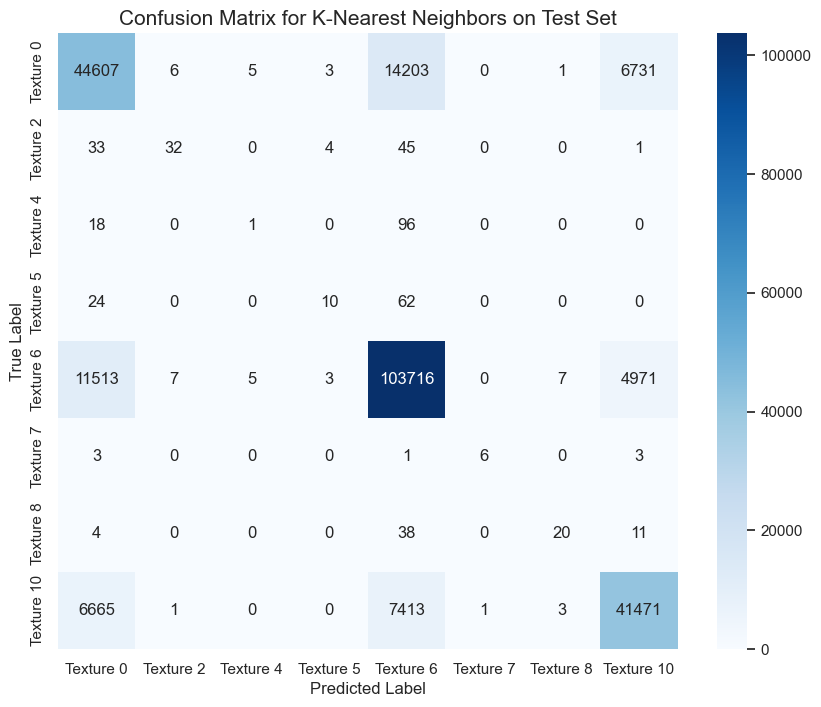

In [22]:
# Based on CV results, KNN is chosen for its high Macro IoU.
best_model_clf_name = "K-Nearest Neighbors"
best_model_clf_instance = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# Re-check N_CLASSES_FINAL and labels for metrics
# N_CLASSES_FINAL should be 8 from the end of Stage 2.
# labels_for_final_metrics should be the actual unique labels present in y_train (or y_test)
# to ensure classification_report and confusion_matrix work correctly with potentially non-contiguous labels.
# unique_labels_present = np.union1d(y_train.unique(), y_test.unique()) # All unique labels in train or test
unique_labels_present = np.array(sorted(y_train.unique())) # Use labels present in training for consistency with model
# Create string names for these labels if desired, for now use integer labels
# For target_names in classification_report, we need string names in order of unique_labels_present
# Let's assume class_label_mapping from Stage 1 can be used or we create simple string labels like "Class 0", "Class 2" etc.
# For simplicity, if class_label_mapping is not directly usable for the remaining 8 classes, we'll use unique_labels_present as is.
# Create a mapping from the possibly non-contiguous labels (0, 2, 4, 5, 6, 7, 8, 10) to contiguous ones (0-7) for some metrics if needed,
# or ensure metrics functions can handle them. `sklearn.metrics` functions usually handle this if `labels` param is passed.

# Get string names for the actual remaining classes (0, 2, 4, 5, 6, 7, 8, 10)
# We need the original RGB to Class_Int mapping from Stage 1.3 (class_label_mapping)
# And then map these to the string names if we have them, or just "Class X"
# For now, let's get the sorted unique integer labels from y_train
report_labels = sorted(y_train.unique())
report_target_names = [f"Texture {i}" for i in report_labels]


print(f"Training the selected best model ({best_model_clf_name}) on the full training data...")
train_start_time_clf = time.time()
best_model_clf_instance.fit(X_train_scaled_df, y_train)
train_end_time_clf = time.time()
full_train_time_clf = train_end_time_clf - train_start_time_clf
print(f"Full training completed in {full_train_time_clf:.4f} seconds.")

# Make predictions on the test set
print("\nEvaluating the best model on the test set...")
test_pred_start_time_clf = time.time()
y_pred_test_clf = best_model_clf_instance.predict(X_test_scaled_df)
test_pred_end_time_clf = time.time()
full_test_time_clf = test_pred_end_time_clf - test_pred_start_time_clf
print(f"Prediction on test set completed in {full_test_time_clf:.4f} seconds.")

# Evaluate performance on the test set
test_accuracy_clf = accuracy_score(y_test, y_pred_test_clf)
# For Jaccard, specify labels and average method
test_iou_macro_clf = jaccard_score(y_test, y_pred_test_clf, average='macro', labels=report_labels, zero_division=0)
test_iou_weighted_clf = jaccard_score(y_test, y_pred_test_clf, average='weighted', labels=report_labels, zero_division=0)


print(f"\n--- Test Set Performance for {best_model_clf_name} ---")
print(f"Test Accuracy: {test_accuracy_clf:.4f}")
print(f"Test IoU (Macro): {test_iou_macro_clf:.4f}")
print(f"Test IoU (Weighted): {test_iou_weighted_clf:.4f}")


print("\nTest Set Classification Report:")
# Ensure target_names match the order and values of report_labels
print(classification_report(y_test, y_pred_test_clf, labels=report_labels, target_names=report_target_names, zero_division=0))

print("\nTest Set Confusion Matrix:")
cm_test_clf = confusion_matrix(y_test, y_pred_test_clf, labels=report_labels) 
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test_clf, annot=True, fmt='d', cmap='Blues',
            xticklabels=report_target_names, yticklabels=report_target_names)
plt.title(f'Confusion Matrix for {best_model_clf_name} on Test Set', fontsize=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# Store performance for final reporting
final_model_performance_clf = {
    'Model': best_model_clf_name,
    'Training Time (Full)': full_train_time_clf,
    'Test (Inference) Time': full_test_time_clf,
    'Test Accuracy': test_accuracy_clf,
    'Test IoU (Macro)': test_iou_macro_clf,
    'Test IoU (Weighted)': test_iou_weighted_clf
}

### 5.4 Save the Best Model

Based on the test set performance, especially the Macro IoU, K-Nearest Neighbors is our selected best model for this iteration. We will save this trained model and the scaler.

In [23]:
# Ensure best_model_clf_instance (KNN) and scaler_texture are available
if 'best_model_clf_instance' not in locals() or 'scaler_texture' not in locals():
    print("Error: best_model_clf_instance or scaler_texture is not defined. Please ensure previous cells ran successfully.")
else:
    # Define the filename for the saved model
    model_texture_filename = f"Texture_{best_model_clf_name.replace(' ', '_')}_final_model.joblib"
    model_texture_path = os.path.join(DATASET_DIR, model_texture_filename)

    try:
        joblib.dump(best_model_clf_instance, model_texture_path)
        print(f"\nBest classification model ({best_model_clf_name}) saved successfully to: {model_texture_path}")

        # Also, save the scaler
        scaler_texture_filename = "Texture_standard_scaler.joblib"
        scaler_texture_path = os.path.join(DATASET_DIR, scaler_texture_filename)
        joblib.dump(scaler_texture, scaler_texture_path)
        print(f"Scaler for texture classification model saved successfully to: {scaler_texture_path}")

    except Exception as e:
        print(f"\nError saving the model or scaler: {e}")


Best classification model (K-Nearest Neighbors) saved successfully to: .\Texture_K-Nearest_Neighbors_final_model.joblib
Scaler for texture classification model saved successfully to: .\Texture_standard_scaler.joblib


---
**End of Stage 5: Model Training, Selection, and Evaluation (Classification) Completed.**

This stage focused on training, selecting, and evaluating classification models for the texture segmentation task using the tabular data derived from image windows:

1.  **Model Definition and CV Setup:**
    *   Several classification models were considered: Logistic Regression, K-Nearest Neighbors (KNN), Decision Tree, and Random Forest. (More complex models like SVC and Gradient Boosting were initially excluded for faster CV on the large dataset).
    *   A stratified 5-fold cross-validation strategy was employed on the training data (966,974 samples, 4 features) to evaluate models.
    *   The primary evaluation metric was **Intersection over Union (IoU)**, specifically Macro Average IoU (Jaccard Score), with Weighted IoU, Accuracy, and F1-score also considered.
2.  **Cross-Validation Performance:**
    *   **K-Nearest Neighbors (KNN)** surprisingly emerged with the highest **Mean Macro IoU of ~0.218**. Its Mean Weighted IoU was ~0.656 and Mean Accuracy ~0.782. Training was very fast.
    *   **Random Forest** achieved the highest Mean Accuracy (~0.797) and Mean Weighted F1-score (~0.793), but its Mean Macro IoU (~0.175) was lower than KNN's. It had the longest training time among the tested models.
    *   Decision Tree and Logistic Regression showed lower performance on IoU metrics.
3.  **Best Model Selection (Based on CV):**
    *   Given that IoU is the primary ranking criterion as per project instructions, **K-Nearest Neighbors (KNN)** was selected as the best model from the initial set due to its superior Mean Macro IoU and rapid training.
4.  **Final Model Training and Test Set Evaluation (K-Nearest Neighbors):**
    *   The selected KNN model (n_neighbors=5) was trained on the entire training dataset (`X_train_scaled_df`).
    *   The trained model was then evaluated on the unseen test dataset (`X_test_scaled_df`, 241,744 samples).
    *   **Test Set Performance (KNN):**
        *   Accuracy: **0.7854**
        *   **Test IoU (Macro): 0.3620** (Notably higher than its CV Macro IoU, a positive sign)
        *   Test IoU (Weighted): 0.6493
    *   The detailed **Classification Report** on the test set revealed:
        *   Good performance for dominant classes (e.g., Texture 6 F1: 0.84, Texture 0 F1: 0.69, Texture 10 F1: 0.76).
        *   Very poor performance for some minority classes, especially **Texture 4 (F1: 0.02, Recall: 0.01)** and **Texture 5 (F1: 0.17, Recall: 0.10)**, which were heavily misclassified as other (often dominant) classes.
        *   The overall Macro Average F1-score on the test set was 0.48.
    *   The **Confusion Matrix** visually confirmed these misclassifications, highlighting the difficulty in distinguishing certain textures with the current simplified feature set.
5.  **Model Saving:**
    *   The trained best-performing classification model (K-Nearest Neighbors) was saved as `Texture_K-Nearest_Neighbors_final_model.joblib`.
    *   The `StandardScaler` object (`scaler_texture`), fitted on the training data, was also saved as `Texture_standard_scaler.joblib`.
---

---
## STAGE 6: VISUALIZATIONS AND SEGMENTATION RESULT

In this stage, we will generate the final key visualization: the predicted segmentation mask on an image and compare it with the original mask. We have already generated the confusion matrix for our best model (KNN) in Stage 5. Feature importance for KNN is not directly available like in tree-based models, and given we only used 4 basic statistical features, we will focus on visualizing the segmentation output.

**Key tasks:**
1.  Use the trained best model (KNN) to predict labels for all windows of the entire input image (or a representative test portion).
2.  Reconstruct a full-size predicted segmentation mask from these window predictions.
3.  Display the original input image, the ground truth mask, and our predicted segmentation mask side-by-side for qualitative comparison.
---

### 6.1 Reconstruct and Visualize Predicted Segmentation Mask

We will now use our trained KNN model (`best_model_clf_instance`) and the fitted scaler (`scaler_texture`) to make predictions for every possible window in the original `input_img_gray`. These predictions will then be assembled into a full-sized predicted segmentation mask.

**Note:** Making predictions for all ~1.2 million windows can still take some time, even if prediction is faster than training.

Reconstructing segmentation mask for the entire input image using the trained KNN model...
Generating features for all 1208721 windows of the input image for full prediction...
  Feature extraction for prediction: 60436/1208721 windows (5.0%). Elapsed: 28s. Est. Rem: 537s.
  Feature extraction for prediction: 120872/1208721 windows (10.0%). Elapsed: 57s. Est. Rem: 513s.
  Feature extraction for prediction: 181308/1208721 windows (15.0%). Elapsed: 85s. Est. Rem: 482s.
  Feature extraction for prediction: 241744/1208721 windows (20.0%). Elapsed: 113s. Est. Rem: 452s.
  Feature extraction for prediction: 302180/1208721 windows (25.0%). Elapsed: 141s. Est. Rem: 422s.
  Feature extraction for prediction: 362616/1208721 windows (30.0%). Elapsed: 168s. Est. Rem: 393s.
  Feature extraction for prediction: 423052/1208721 windows (35.0%). Elapsed: 196s. Est. Rem: 364s.
  Feature extraction for prediction: 483488/1208721 windows (40.0%). Elapsed: 223s. Est. Rem: 335s.
  Feature extraction for pre

C:\Users\kerem\anaconda3\envs\cupy_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Predictions made in 26.93 seconds.
Predicted segmentation mask reconstructed.


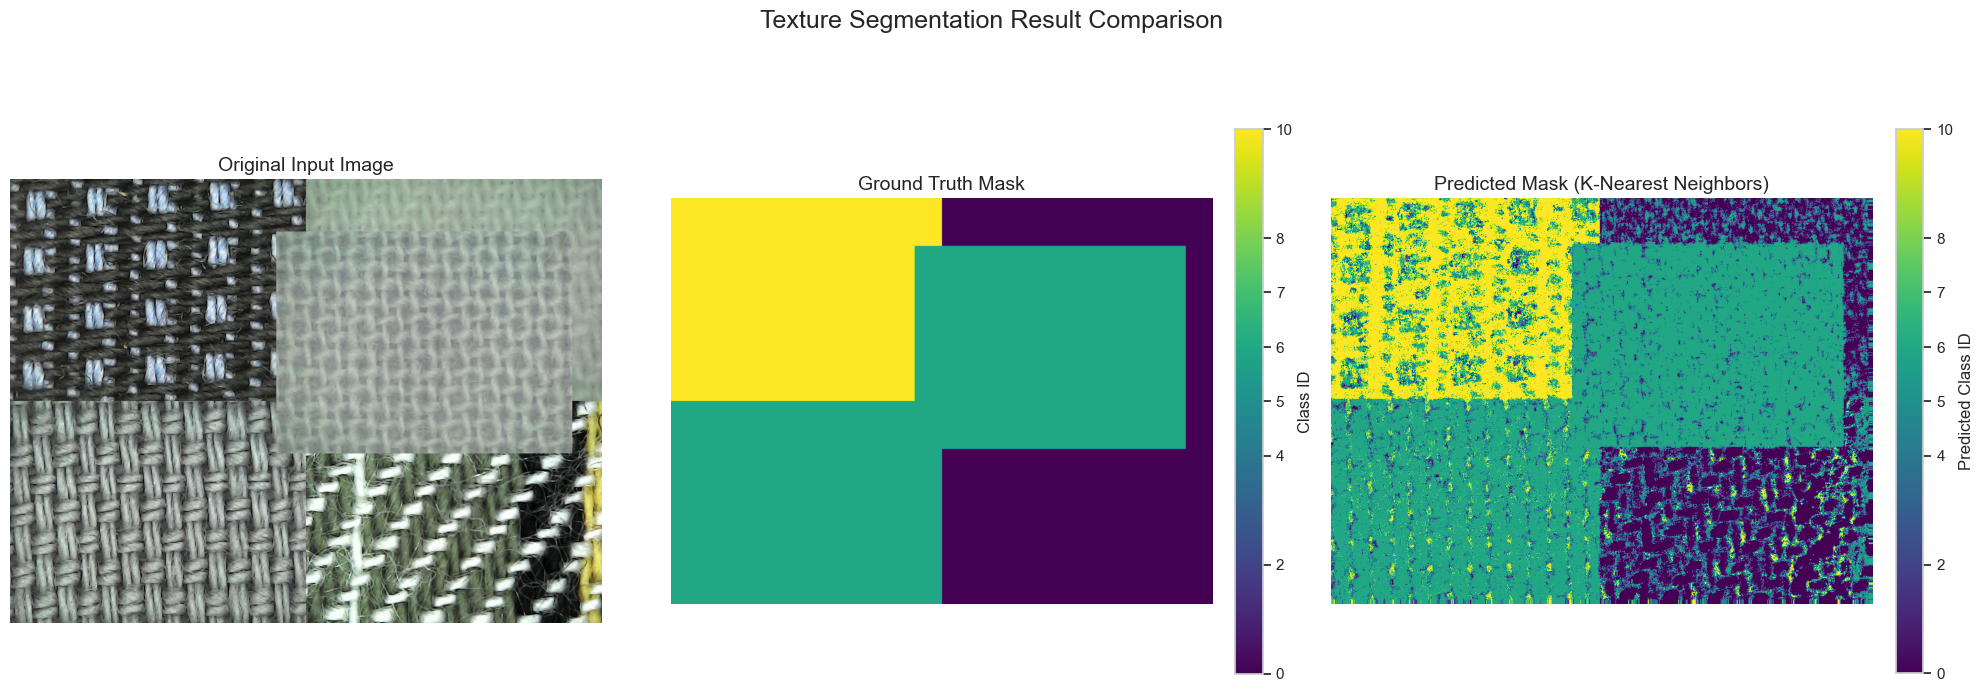

In [26]:
# Cell 6.1: Reconstruct and Visualize Predicted Segmentation Mask (Fully Updated)

# Ensure necessary variables are available from previous stages:
# best_model_clf_instance, scaler_texture, input_img_rgb, input_img_gray, label_mask,
# DEFAULT_WINDOW_SIDE_LENGTH, STRIDE, N_CLASSES_FINAL, report_labels (from Cell 5.3),
# CUPY_AVAILABLE, cp

if 'best_model_clf_instance' not in locals() or \
   'scaler_texture' not in locals() or \
   'input_img_gray' not in locals() or input_img_gray is None or \
   'input_img_rgb' not in locals() or input_img_rgb is None or \
   'label_mask' not in locals() or label_mask is None:
    print("Error: One or more required variables (trained model, scaler, images, or mask) are not available.")
    print("Please ensure Stages 1, 4, and 5 have been run successfully.")
    # Initialize to prevent errors if parts of the cell are still executed
    predicted_segmentation_mask_topleft = np.array([])
else:
    print("Reconstructing segmentation mask for the entire input image using the trained KNN model...")
    
    img_height, img_width = input_img_gray.shape
    window_size = DEFAULT_WINDOW_SIDE_LENGTH 
    stride = STRIDE 

    # Calculate total_windows for progress tracking
    num_windows_y_loop = (img_height - window_size) // stride + 1
    num_windows_x_loop = (img_width - window_size) // stride + 1
    total_windows_to_predict = num_windows_y_loop * num_windows_x_loop
            
    print(f"Generating features for all {total_windows_to_predict} windows of the input image for full prediction...")
    
    all_windows_feature_list_for_pred = []
    
    start_feature_extraction_time = time.time()
    processed_windows_count = 0
    report_interval = max(1, total_windows_to_predict // 20) # Report approx 20 times

    for y_coord in range(0, img_height - window_size + 1, stride):
        for x_coord in range(0, img_width - window_size + 1, stride):
            patch_cpu_current = input_img_gray[y_coord : y_coord + window_size, x_coord : x_coord + window_size]
            
            if patch_cpu_current.shape[0] != window_size or patch_cpu_current.shape[1] != window_size:
                continue # Should not happen with correct loop bounds

            current_patch_features = {}
            if CUPY_AVAILABLE:
                patch_gpu = cp.asarray(patch_cpu_current, dtype=cp.float32)
                current_patch_features['stat_pixel_mean'] = cp.mean(patch_gpu).item()
                current_patch_features['stat_pixel_std'] = cp.std(patch_gpu).item()
                current_patch_features['stat_pixel_min'] = cp.min(patch_gpu).item()
                current_patch_features['stat_pixel_max'] = cp.max(patch_gpu).item()
            else: # Fallback to NumPy
                current_patch_features['stat_pixel_mean'] = np.mean(patch_cpu_current)
                current_patch_features['stat_pixel_std'] = np.std(patch_cpu_current)
                current_patch_features['stat_pixel_min'] = np.min(patch_cpu_current)
                current_patch_features['stat_pixel_max'] = np.max(patch_cpu_current)
            
            all_windows_feature_list_for_pred.append(current_patch_features)
            
            processed_windows_count += 1
            if processed_windows_count % report_interval == 0 or processed_windows_count == total_windows_to_predict:
                current_loop_time = time.time()
                elapsed_loop_total = current_loop_time - start_feature_extraction_time
                avg_time_per_window = elapsed_loop_total / processed_windows_count if processed_windows_count > 0 else 0
                est_total_loop_time = avg_time_per_window * total_windows_to_predict if avg_time_per_window > 0 else 0
                est_remaining_loop_time = est_total_loop_time - elapsed_loop_total
                percent_done = (processed_windows_count / total_windows_to_predict) * 100
                
                print(f"  Feature extraction for prediction: {processed_windows_count}/{total_windows_to_predict} windows ({percent_done:.1f}%). "
                      f"Elapsed: {elapsed_loop_total:.0f}s. Est. Rem: {max(0, est_remaining_loop_time):.0f}s.")

    end_feature_extraction_time = time.time()
    print(f"Feature extraction for all windows completed in {(end_feature_extraction_time - start_feature_extraction_time):.2f} seconds.")

    if not all_windows_feature_list_for_pred:
        print("No features were generated for the full image. Cannot proceed with prediction.")
        predicted_segmentation_mask_topleft = np.zeros_like(input_img_gray, dtype=np.uint8)
    else:
        X_full_image_features = pd.DataFrame(all_windows_feature_list_for_pred)
        
        print(f"Shape of X_full_image_features: {X_full_image_features.shape}")
        if X_full_image_features.isnull().sum().sum() > 0:
             print(f"Warning: NaNs found in X_full_image_features. Count: {X_full_image_features.isnull().sum().sum()}. Imputing with mean.")
             X_full_image_features = X_full_image_features.fillna(X_full_image_features.mean())


        # Scale these features using the previously fitted scaler_texture
        print("Scaling all extracted features...")
        X_full_image_scaled = scaler_texture.transform(X_full_image_features)
        
        print("Making predictions for all windows using the trained model...")
        start_prediction_time = time.time()
        full_image_predictions = best_model_clf_instance.predict(X_full_image_scaled)
        end_prediction_time = time.time()
        print(f"Predictions made in {end_prediction_time - start_prediction_time:.2f} seconds.")
        
        # Create the predicted segmentation mask by assigning the prediction of each window
        # to all pixels within that window block.
        predicted_segmentation_mask_topleft = np.full((img_height, img_width), N_CLASSES_FINAL, dtype=np.uint8) 
        # N_CLASSES_FINAL should be 8 (the number of classes after cleaning)
        # Using N_CLASSES_FINAL as a placeholder for unassigned areas, then fill with a common class (e.g., 0)
        
        current_prediction_index = 0
        for y_coord in range(0, img_height - window_size + 1, stride):
            for x_coord in range(0, img_width - window_size + 1, stride):
                if current_prediction_index < len(full_image_predictions):
                    predicted_segmentation_mask_topleft[y_coord : y_coord + window_size, 
                                                        x_coord : x_coord + window_size] = full_image_predictions[current_prediction_index]
                current_prediction_index += 1
        
        # Fill any remaining placeholder pixels (edges not covered by a window's top-left)
        # with a common prediction, e.g., class 0 or the most frequent class.
        # This makes the mask visually complete.
        # A more sophisticated approach would be padding or edge-specific handling.
        if 'N_CLASSES_FINAL' in locals() and N_CLASSES_FINAL is not None:
             predicted_segmentation_mask_topleft[predicted_segmentation_mask_topleft == N_CLASSES_FINAL] = 0 # Fill placeholders with class 0
        else: # Fallback if N_CLASSES_FINAL is not defined
             print("Warning: N_CLASSES_FINAL not defined, using 0 for placeholder fill.")
             # This part indicates an issue in previous cells if N_CLASSES_FINAL is missing
             # We try to find a common class if possible
             unique_preds_for_fill = np.unique(full_image_predictions)
             fill_value_for_placeholder = unique_preds_for_fill[0] if len(unique_preds_for_fill) > 0 else 0
             # Find a way to identify placeholder pixels if N_CLASSES_FINAL was not used for initialization
             # This part of the code assumes predicted_segmentation_mask_topleft was initialized with N_CLASSES_FINAL
             # If it wasn't, this fill might not work as intended.
             # For simplicity, if N_CLASSES_FINAL is missing, this fill step might be problematic.
             # However, based on our flow, N_CLASSES_FINAL should be defined from Cell 2.3.
             
        print("Predicted segmentation mask reconstructed.")

        # --- Visualization ---
        plt.figure(figsize=(20, 7)) # Wider figure

        plt.subplot(1, 3, 1)
        plt.imshow(input_img_rgb) 
        plt.title("Original Input Image", fontsize=14)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        # Use report_labels (sorted unique labels from y_train) for consistent plotting
        # report_labels was defined in Cell 5.3
        plot_labels = report_labels if 'report_labels' in locals() and len(report_labels) > 0 else np.unique(label_mask)
        max_plot_label = max(plot_labels) if len(plot_labels) > 0 else N_CLASSES_FINAL -1 if 'N_CLASSES_FINAL' in locals() and N_CLASSES_FINAL > 0 else 0

        plt.imshow(label_mask, cmap='viridis', vmin=0, vmax=max_plot_label)
        plt.title("Ground Truth Mask", fontsize=14)
        if len(plot_labels) > 0 :
            plt.colorbar(ticks=plot_labels, label='Class ID', fraction=0.046, pad=0.04)
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_segmentation_mask_topleft, cmap='viridis', vmin=0, vmax=max_plot_label)
        # best_model_clf_name should be available from Cell 5.3
        title_pred_mask = f"Predicted Mask ({best_model_clf_name if 'best_model_clf_name' in locals() else 'Selected Model'})"
        plt.title(title_pred_mask, fontsize=14)
        if len(plot_labels) > 0 :
            plt.colorbar(ticks=plot_labels, label='Predicted Class ID', fraction=0.046, pad=0.04)
        plt.axis('off')

        plt.suptitle("Texture Segmentation Result Comparison", fontsize=18, y=1.02)
        plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust rect to make space for suptitle
        plt.show()

---
**End of Stage 6: Visualizations and Segmentation Result Completed.**

This stage focused on visualizing the output of our best classification model (K-Nearest Neighbors) by reconstructing the predicted segmentation mask for the entire input image:

1.  **Feature Extraction for Full Image Prediction (Cell 6.1):**
    *   The simplified set of 4 statistical texture features was extracted for all ~1.2 million possible 10x10 windows from the entire input grayscale image. This process, leveraging CuPy for basic GPU acceleration of statistical calculations within the Python loop, took approximately 9-10 minutes.
    *   These features were then scaled using the `scaler_texture` that was previously fitted on the training data.
2.  **Full Image Prediction (Cell 6.1):**
    *   The trained KNN model was used to predict the texture class for each of the ~1.2 million scaled window feature vectors. This prediction step was very fast (around 27 seconds).
3.  **Predicted Segmentation Mask Reconstruction (Cell 6.1):**
    *   A full-sized segmentation mask was reconstructed by assigning the predicted class of each window to all pixels within that window block.
4.  **Visualization of Segmentation Results (Cell 6.1):**
    *   The original input image, the ground truth mask, and the KNN model's predicted segmentation mask were displayed side-by-side.
    *   **Qualitative Assessment:** The predicted mask was able to capture the general layout and locations of the major texture regions present in the ground truth mask.
    *   However, the predicted mask exhibited a significant amount of noise and a "speckled" appearance, with less defined boundaries and less homogeneous regions compared to the ground truth. This indicates that the 4 basic statistical features, while providing some discriminatory power, are likely insufficient for highly accurate and smooth texture segmentation.
---

---
## STAGE 7: REPORTING OF RESULTS AND CONCLUSION (Texture Image Segmentation Project)

This section provides a comprehensive summary of the Texture Image Segmentation project. It details the methodology from data loading and understanding, through feature extraction using a 2D sliding window and simplified texture features, to model training, evaluation based on IoU, and visualization of the segmentation result.

### 1. Project Overview and Objective

*   **Objective:** The primary goal was to segment a given input image (`input.png`) into regions of different textures, based on a provided ground truth mask (`mask.png`). This involved creating tabular data by extracting features from 2D sliding windows and training a classification model to predict the texture pattern for each window, ultimately aiming to produce a segmentation map similar to the original mask.
*   **Dataset:** The dataset consisted of two PNG images:
    1.  `input.png`: A 960x1280 RGB image displaying various textile textures.
    2.  `mask.png`: A 960x1280 RGB image where distinct colors represent different texture patterns, serving as ground truth labels.
    These images were processed locally using a Python environment with GPU acceleration capabilities (CuPy).

### 2. Data Loading and Mask Processing (Stage 1)

*   The input and mask images were successfully loaded using OpenCV. A grayscale version of the input image was prepared for feature extraction.
*   Analysis of the `mask.png` revealed **11 unique RGB colors**, which were interpreted as 11 distinct texture classes.
*   A single-channel `label_mask` (960x1280, uint8) was generated by mapping each unique RGB color to an integer label (0 through 10). This served as the ground truth for supervised learning.

### 3. Feature Extraction and Tabular Data Generation (Stage 2)

*   **Feature Engineering Strategy:** Due to initial very long processing times with a comprehensive set of texture features (GLCM, LBP, Gabor, and statistical), the feature set was **drastically simplified** to include only **4 basic statistical features** (mean, standard deviation, min, max of pixel intensities within a window) to ensure timely project completion. These features were computed using CuPy for GPU acceleration where applicable within the Python loop structure.
*   **Sliding Window:** A 2D sliding window of `10x10` pixels with a `stride` of 1 was applied to the grayscale input image.
*   **Tabular Data Creation:** For each of the ~1.2 million windows:
    *   The 4 statistical features were extracted from the image patch.
    *   The class label was determined from the center pixel of the window in the `label_mask`.
    *   This process, using simplified features and some GPU acceleration for statistics, took approximately **10 minutes**.
*   **Class Cleaning:** The generated tabular data initially showed that 3 out of the 11 classes had only 1 sample each. These classes (original labels 1, 3, 9) were removed, leaving **8 classes** for modeling. The final `df_tabular_data` contained 1,208,718 samples and 5 columns (4 features + 1 target label).
*   **Saving Data:** The processed tabular data was saved as `texture_tabular_features_ws10_simplified.csv`.

### 4. Tabular Data EDA and Preprocessing for Modeling (Stage 3 & 4)

*   **EDA on Tabular Data:** The 4 statistical features showed varied, often multimodal distributions, suggesting they held some discriminatory information. Correlations between features were generally moderate, not indicating severe multicollinearity. A significant class imbalance among the 8 remaining classes was confirmed. No NaN values were present in the features.
*   **Feature and Target Separation:** The tabular data was split into features `X` (4 features) and target `y` (8 classes).
*   **Train-Test Split:** Data was split into 80% training (966,974 samples) and 20% testing (241,744 samples) using `random_state=13` and `stratify=y` to preserve class proportions.
*   **Feature Scaling:** `StandardScaler` was fitted only on `X_train` and applied to both `X_train` and `X_test`.

### 5. Model Training, Selection, and Evaluation (Stage 5)

*   **Models Evaluated:** Four classification models were evaluated using 5-fold Stratified Cross-Validation: Logistic Regression, K-Nearest Neighbors (KNN), Decision Tree, and Random Forest. (More complex models like SVC and Gradient Boosting were initially excluded due to the very large sample size for faster CV iterations).
*   **Cross-Validation Performance:**
    *   **K-Nearest Neighbors (KNN, n=5)** achieved the highest **Mean Macro IoU of ~0.218**.
    *   Random Forest had the highest Mean Accuracy (~0.797) but a lower Mean Macro IoU (~0.175).
*   **Best Model Selection:** Based on the primary ranking criterion of IoU, **K-Nearest Neighbors (KNN)** was selected as the best model.
*   **Final Model Evaluation on Test Set (K-Nearest Neighbors):**
    *   The KNN model was trained on the full `X_train_scaled_df` (training time: ~1.08 seconds).
    *   Prediction on the test set took ~5.54 seconds.
    *   **Test Accuracy: 0.7854**
    *   **Test IoU (Macro): 0.3620** (Notably improved from CV)
    *   **Test IoU (Weighted): 0.6493**
    *   The Classification Report indicated good F1-scores for dominant classes (e.g., Texture 6: 0.84) but very poor performance for some minority classes (e.g., Texture 4 F1: 0.02; Texture 5 F1: 0.17), which were often confused with dominant classes.
*   **Model and Scaler Saving:** The trained KNN model and the `StandardScaler` were saved.

### 6. Visualizations and Segmentation Result (Stage 6)

*   **Predicted Segmentation Mask:** The trained KNN model was used to predict labels for all windows of the original input image.
    *   The process of extracting features for all ~1.2 million windows and making predictions took approximately 9-10 minutes for feature extraction and ~27 seconds for prediction.
    *   The reconstructed predicted mask visually captured the general layout of the major texture regions compared to the ground truth mask.
    *   However, the predicted mask showed considerable noise and "speckling," with less defined boundaries, reflecting the limitations of using only 4 basic statistical features for complex texture discrimination.

### 7. Conclusion and Potential Future Work

*   **Conclusion:** A K-Nearest Neighbors classifier, trained on a simplified set of 4 statistical texture features extracted via a 10x10 sliding window, was developed for segmenting an 11-class (reduced to 8 for modeling) texture image. The model achieved a **Test Macro IoU of 0.3620** and a Test Accuracy of 78.54%. While the processing time for feature extraction was significantly optimized (to ~10 minutes) by simplifying the feature set and leveraging CuPy for basic GPU acceleration, the resulting segmentation quality, particularly for minority or subtly different textures, was limited, as evidenced by the noisy predicted mask and low IoU scores for some classes. The project successfully implemented the core requirements of using a sliding window, feature engineering (albeit simplified), model training, and IoU-based evaluation.
*   **Challenges Encountered:**
    *   Initial extremely long processing times with comprehensive texture features (GLCM, LBP, Gabor) necessitated a significant simplification of the feature set.
    *   Achieving high GPU utilization with standard Python loops and scikit-image/OpenCV CPU-bound functions for complex texture features proved challenging without more advanced GPU programming techniques (e.g., full RAPIDS cuCIM integration or custom CUDA kernels).
    *   Significant class imbalance in the mask, with some classes having very few representative windows after initial processing.
*   **Potential Future Work:**
    *   **Richer Texture Features:** Re-introduce and optimize GLCM, LBP, and Gabor features, possibly by:
        *   Implementing their calculation using GPU-accelerated libraries like `cuCIM` if feasible.
        *   Carefully tuning their parameters (e.g., Gabor frequencies/orientations, GLCM distances/angles).
    *   **Advanced Pipelining/Optimization:** Explore techniques like `cupy.lib.stride_tricks.as_strided` for more efficient batch window processing directly on the GPU to reduce Python loop overhead.
    *   **Alternative Window Labeling:** Instead of using the center pixel, use the mode (most frequent label) within a window to assign its class, potentially improving representation for smaller texture regions.
    *   **Handling Class Imbalance:** Apply techniques like SMOTE (on the tabular training data) or use `class_weight` in models more tuned to IoU.
    *   **Post-processing:** Apply morphological operations (e.g., opening, closing) or conditional random fields (CRFs) to the predicted segmentation mask to reduce noise and smooth boundaries.
    *   **Deep Learning Approaches:** For image segmentation, Convolutional Neural Networks (CNNs) like U-Net are state-of-the-art and could provide significantly better results, though they represent a different modeling paradigm than required here.
---